In [2]:
#from mpl_toolkits.basemap import Basemap, cm
import os.path
import os
import sys
from matplotlib import rcParams
from matplotlib.animation import ArtistAnimation
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from datetime import datetime, timedelta
from siphon.cdmr import Dataset
import numpy as np
import numpy.ma as ma
import netCDF4

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
import cartopy.io.shapereader as shpreader
from cartopy.feature import ShapelyFeature

from siphon.catalog import TDSCatalog
from siphon.ncss import NCSS
import scipy.ndimage as ndimage
import scipy.signal as signal

from metpy.plots import StationPlot
from metpy.plots.wx_symbols import sky_cover
from metpy.calc import (bunkers_storm_motion, bulk_shear, dewpoint, dewpoint_from_relative_humidity, dry_lapse, moist_lapse,
                        vapor_pressure, saturation_vapor_pressure, wind_speed, wind_direction, pressure_to_height_std,
                        mixing_ratio, cape_cin, wind_components, height_to_pressure_std, equivalent_potential_temperature,
                        parcel_profile, precipitable_water, storm_relative_helicity, mean_pressure_weighted, 
                        most_unstable_cape_cin, most_unstable_parcel, supercell_composite, significant_tornado, get_layer,
                        relative_humidity_from_dewpoint, surface_based_cape_cin, mixed_layer_cape_cin,
                        surface_based_cape_cin, potential_temperature, wind_direction, add_pressure_to_height,
                        add_height_to_pressure, divergence, vorticity, lat_lon_grid_deltas, mixed_parcel,
                        most_unstable_parcel, lcl, lfc, mixing_ratio_from_relative_humidity, el,  cape_cin,
                        height_to_pressure_std, dewpoint_from_relative_humidity)

from metpy.units import units
from metpy.plots import SkewT, Hodograph
from metpy.interpolate import interpolate_1d as metinterp, log_interpolate_1d
from metpy.calc.tools import get_layer, get_layer_heights
from metpy.plots.declarative import BarbPlot, ContourPlot, FilledContourPlot, MapPanel, PanelContainer, PlotObs

import sharppy
import sharppy.sharptab.profile as profile
import sharppy.sharptab.interp as interp
import sharppy.sharptab.winds as winds
import sharppy.sharptab.utils as utils
import sharppy.sharptab.params as params
import sharppy.sharptab.thermo as thermo

import pickle
import csv
import pandas as pd
import xarray as xr
import seaborn as sns
from scipy import stats

In [3]:
def earth_relative_wind_components(ugrd, vgrd):
    """Calculate the north-relative components of the wind from the grid-relative
    components using Cartopy transform_vectors.

    Parameters
    ----------
        ugrd : Xarray DataArray (M, N)
            grid relative u-component of the wind
        vgrd : Xarray DataArray (M, N)
            grid relative v-component of the wind

    Returns
    -------
        unr, vnr : tuple of array-like Quantity
            The north-relative wind components in the X (East-West) and Y (North-South)
            directions, respectively.
    """
    #if 'crs' not in list(ugrd.coords):
    #    raise ValueError('No CRS in coordinate, be sure to use the MetPy accessor parse_cf()')

    data_crs = ugrd.metpy.cartopy_crs

    x = ugrd.x.values
    y = ugrd.y.values

    xx, yy = np.meshgrid(x, y)

    ut, vt = ccrs.PlateCarree().transform_vectors(data_crs, xx, yy, ugrd.values, vgrd.values)

    uer = ut * units(ugrd.units)
    ver = vt * units(vgrd.units)

    return uer, ver

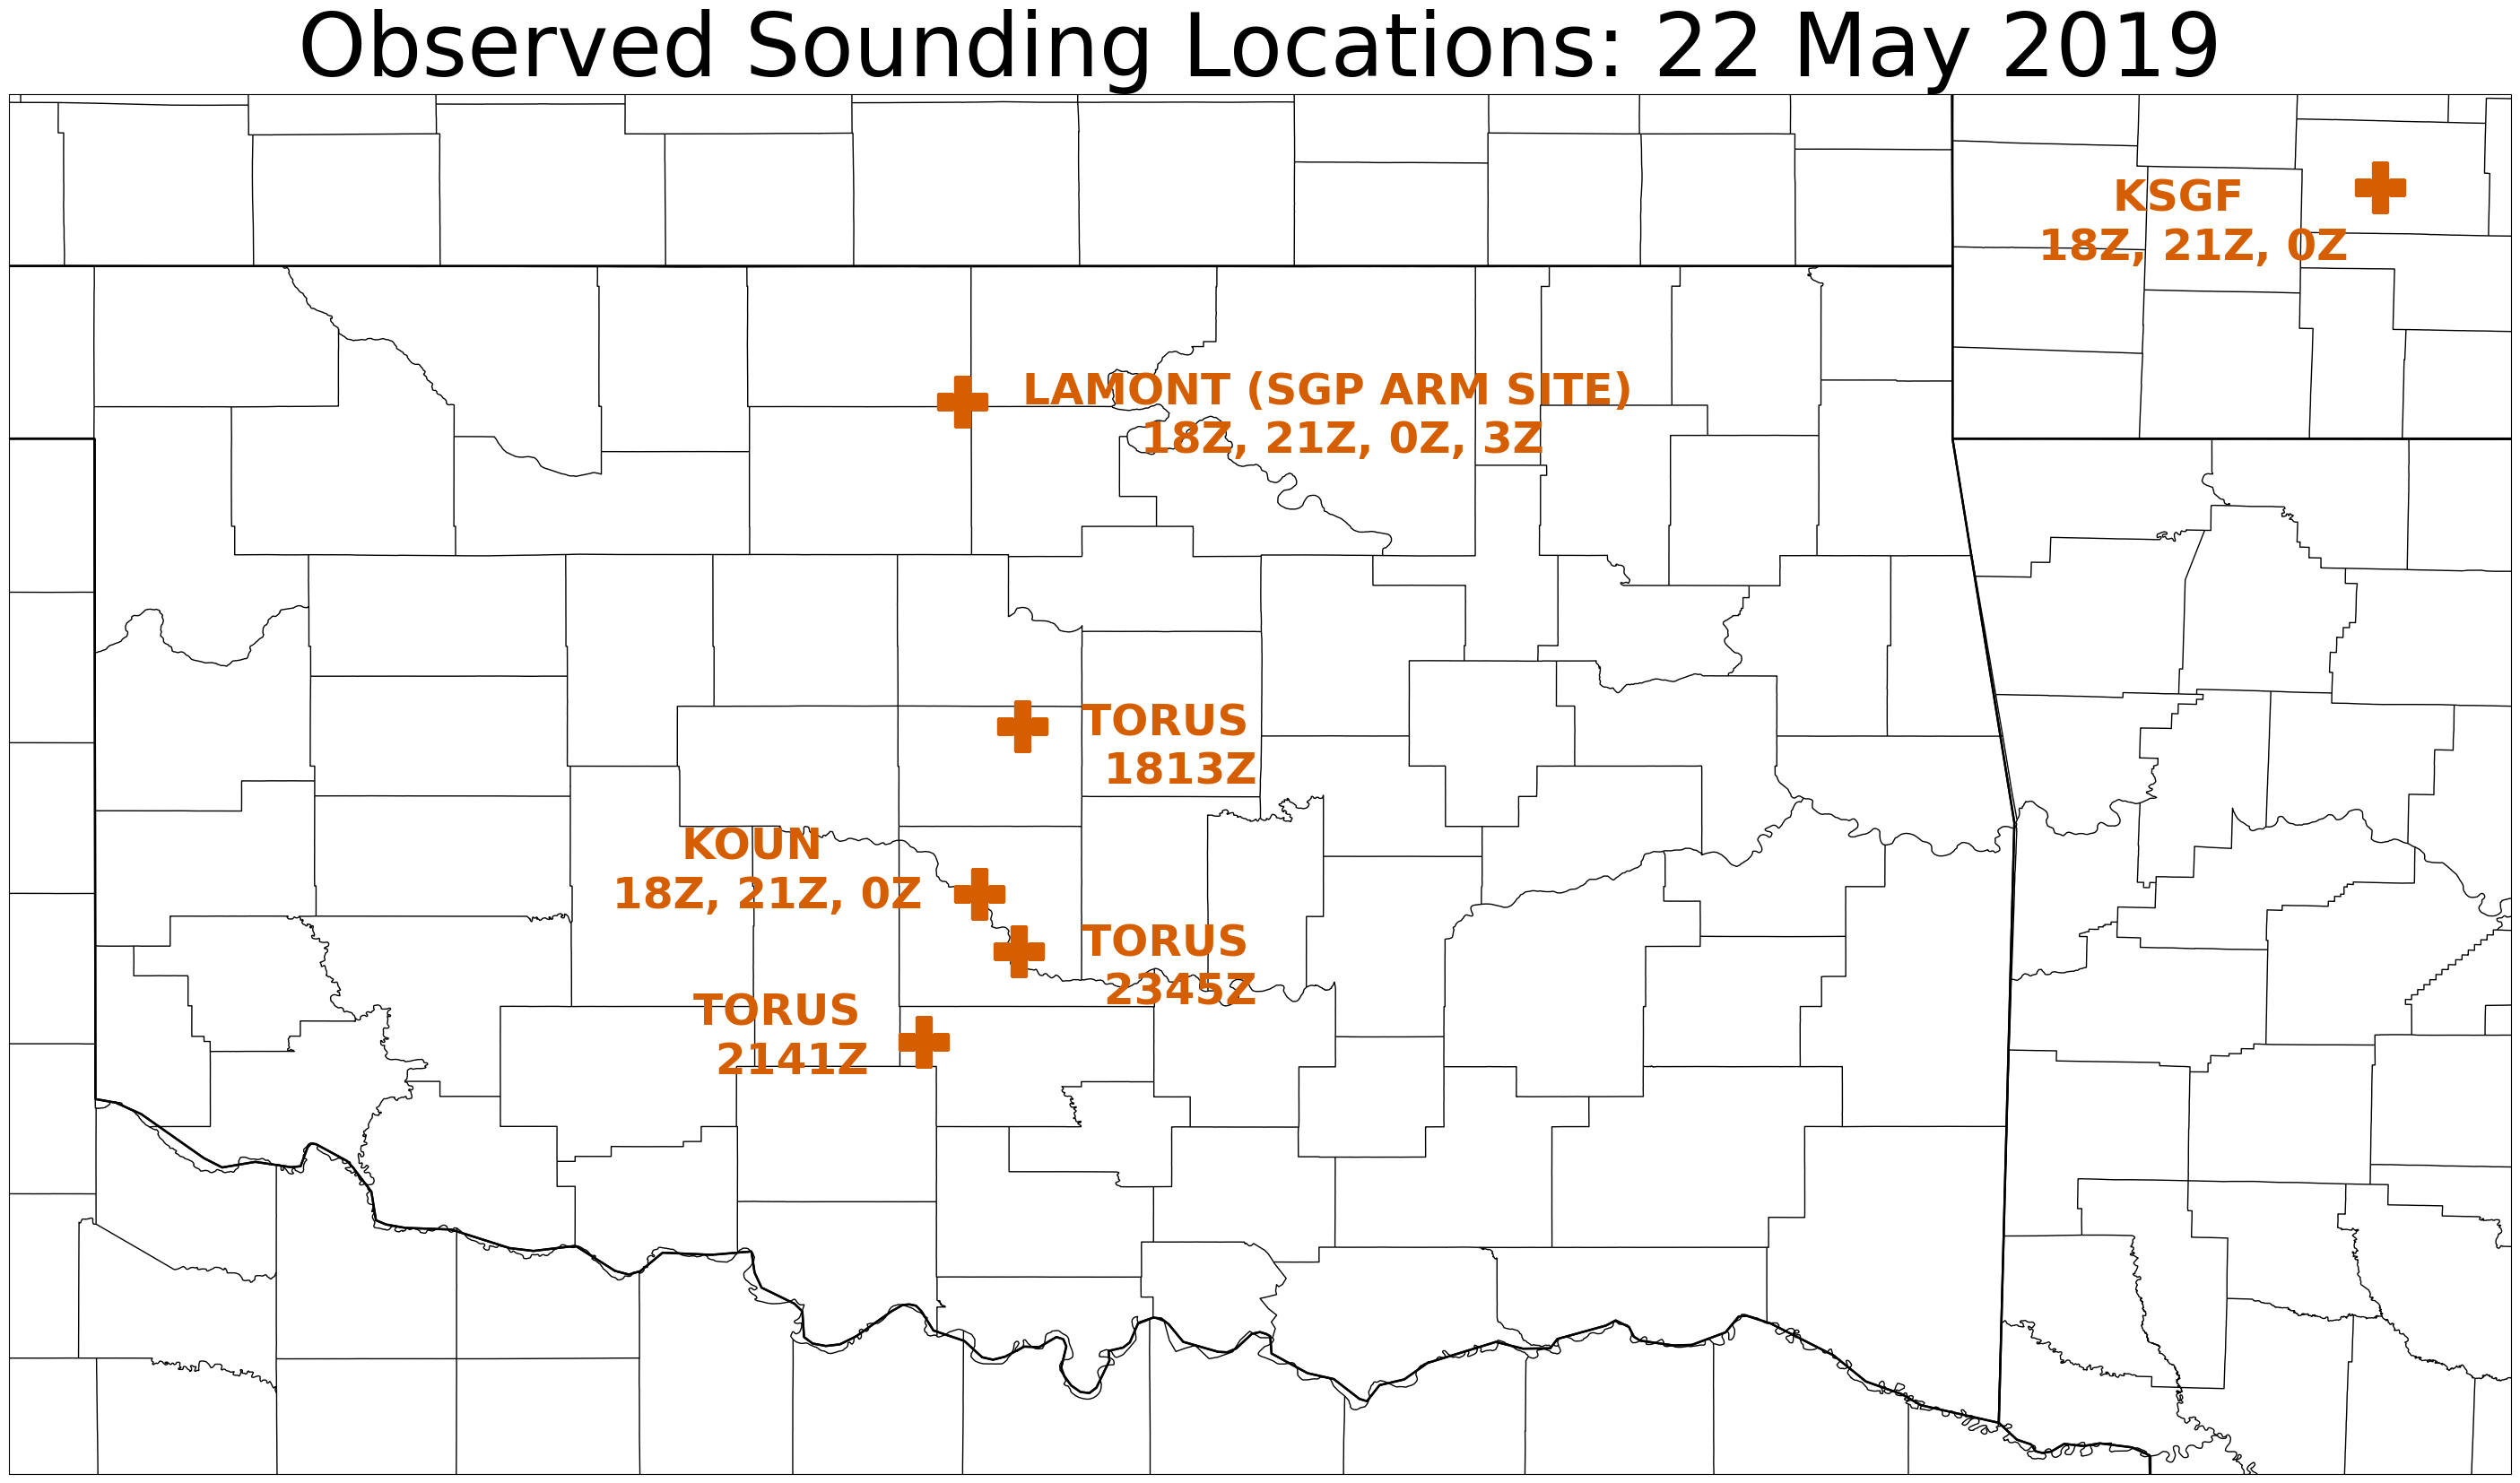

In [5]:
reader = shpreader.Reader(r"D:/THESIS/Thesis GIS Data/County1010/countyl010g.shp")
counties = list(reader.geometries())
COUNTIES = cfeature.ShapelyFeature(counties, ccrs.PlateCarree())

reader1 = shpreader.Reader(r"D:/THESIS/Thesis GIS Data/watches_201905221800_201905222232/watches_201905221800_201905222232.shp")
watchboxes = list(reader1.geometries())
WATCHES = cfeature.ShapelyFeature(watchboxes, ccrs.PlateCarree())

proj = ccrs.PlateCarree()

fig=plt.figure(figsize = (36,36))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.STATES.with_scale('50m'), linestyle='-', edgecolor='black', linewidth=1.75)
ax.add_feature(COUNTIES, facecolor='none', edgecolor='black', linewidth=1.0)
#ax.add_feature(WATCHES, facecolor='none', edgecolor='red', linewidth=4.0)
#ax.set_extent([-104, -93, 32, 39])
ax.set_extent([-100.25, -93, 33.5, 37.5])
#ax.set_extent([-100.25, -94.0, 33.0, 37.8])


#df1 = pd.read_csv("C:/Users/kyled/Desktop/NI_Points_CSVs/5_22_VerticalProfs_QC.csv")
markersize = 40

    
#Norman Soundings/1529z 
ax.plot(-97.4381, 35.1809, 'P', linewidth=10, markersize=markersize, transform = ccrs.PlateCarree(), color='#D55E00')
ax.text(0.30, 0.41, 'KOUN \n 18Z, 21Z, 0Z', horizontalalignment='center', transform=ax.transAxes, color='#D55E00', fontsize=35, weight='bold')

#Lamont (ARM site) Soundings
ax.plot(-97.48781, 36.60760, 'P', linewidth=10, markersize=markersize, transform = ccrs.PlateCarree(), color='#D55E00')
ax.text(0.53, 0.740, 'LAMONT (SGP ARM SITE) \n 18Z, 21Z, 0Z, 3Z', horizontalalignment='center', transform=ax.transAxes, color='#D55E00', fontsize=35, weight='bold')

#1813 Sounding site
ax.plot(-97.3128, 35.6668, 'P', linewidth=10, markersize=markersize, transform = ccrs.PlateCarree(), color='#D55E00')
ax.text(0.465, 0.500, 'TORUS \n 1813Z', horizontalalignment='center', transform=ax.transAxes, color='#D55E00', fontsize=35, weight='bold')

#2141 Soudning Site
ax.plot(-97.5986, 34.7526, 'P', linewidth=10, markersize=markersize, transform = ccrs.PlateCarree(), color='#D55E00')
ax.text(0.31, 0.29, 'TORUS \n 2141Z', horizontalalignment='center', transform=ax.transAxes, color='#D55E00', fontsize=35, weight='bold')

#2345 Sounding Site
ax.plot(-97.3244, 35.0158, 'P', linewidth=10, markersize=markersize, transform = ccrs.PlateCarree(), color='#D55E00')
ax.text(0.465, 0.34, 'TORUS \n 2345Z', horizontalalignment='center', transform=ax.transAxes, color='#D55E00', fontsize=35, weight='bold')

#ax.plot(-93.4007, 37.2350, '*', linewidth=10, markersize=markersize, transform = ccrs.PlateCarree(), color='black')

#KDDC
ax.plot(-99.97, 37.76, 'P', linewidth=10, markersize=markersize, transform = ccrs.PlateCarree(), color='red')
#Amarillo
ax.plot(-101.7, 35.23, 'P', linewidth=10, markersize=markersize, transform = ccrs.PlateCarree(), color='red')
#Springfield
ax.plot(-93.38, 37.23, 'P', linewidth=10, markersize=markersize, transform = ccrs.PlateCarree(), color='#D55E00')
ax.text(0.87, 0.88, 'KSGF \n 18Z, 21Z, 0Z', horizontalalignment='center', transform=ax.transAxes, color='#D55E00', fontsize=35, weight='bold')
#DFW
ax.plot(-97.30, 32.83, 'P', linewidth=10, markersize=markersize, transform = ccrs.PlateCarree(), color='red')
#KSHV
ax.plot(-93.78, 32.46, 'P', linewidth=10, markersize=markersize, transform = ccrs.PlateCarree(), color='red')

plt.title("Observed Sounding Locations: 22 May 2019", fontsize=70)

plt.show()

In [54]:
COMP = data1.variables['Composite_reflectivity_entire_atmosphere'][:]
COMP[0].shape
#theta_e[0][0].shape
#SFCP
print(COMP[0])
print(np.amax(COMP[0]))

[[-10.     -10.     -10.     ... -10.     -10.     -10.    ]
 [-10.     -10.     -10.     ... -10.     -10.     -10.    ]
 [-10.     -10.     -10.     ... -10.     -10.     -10.    ]
 ...
 [ 21.5     18.9375  15.5625 ... -10.     -10.     -10.    ]
 [ 23.5     20.75    16.0625 ... -10.     -10.     -10.    ]
 [ 25.0625  21.5625  16.0625 ... -10.     -10.     -10.    ]]
43.5625


In [4]:
def radar_colormap():
    nws_reflectivity_colors = [
    "#646464", # ND
    "#ccffff", # -30
    "#cc99cc", # -25
    "#996699", # -20
    "#663366", # -15
    "#cccc99", # -10
    "#999966", # -5
    "#646464", # 0
    "#04e9e7", # 5
    "#019ff4", # 10
    "#0300f4", # 15
    "#02fd02", # 20
    "#01c501", # 25
    "#008e00", # 30
    "#fdf802", # 35
    "#e5bc00", # 40
    "#fd9500", # 45
    "#fd0000", # 50
    "#d40000", # 55
    "#bc0000", # 60
    "#f800fd", # 65
    "#9854c6", # 70
    "#fdfdfd" # 75
    ]

    return matplotlib.colors.ListedColormap(nws_reflectivity_colors)

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

import ctables
import matplotlib.colors as colors

In [5]:
year=2019
month=5
day = 22
hour = 23
Hour = hour

time_start = datetime(int(year), int(month), int(day), int(hour), 0) # Our specified time
hour = time_start.hour
if hour < 10:
    hour = '0'+str(hour)
day = time_start.day
if day < 10:
    day = '0'+str(day)
month = time_start.month
if month < 10:
    month = '0'+str(month)
    
cat = TDSCatalog('https://www.ncei.noaa.gov/thredds/catalog/model-rap130anl-old/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/catalog.html?dataset=rap130anl-old/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/rap_130_'+str(time_start.year)+str(month)+str(day)+'_'+str(hour)+'00_000.grb2')

D:\Anaconda3\envs\THESIS\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://www.ncei.noaa.gov/thredds/catalog/model-rap130anl-old/201905/20190522/catalog.html?dataset=rap130anl-old/201905/20190522/rap_130_20190522_2300_000.grb2 returned HTML. Changing to: https://www.ncei.noaa.gov/thredds/catalog/model-rap130anl-old/201905/20190522/catalog.xml?dataset=rap130anl-old/201905/20190522/rap_130_20190522_2300_000.grb2
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,


In [7]:
latest_ds = list(cat.datasets.values())[0]
#print(latest_ds.access_urls)
ncss = NCSS(latest_ds.access_urls['NetcdfSubset'])
query = ncss.query()
query.variables('Vertical_velocity_pressure_isobaric').variables('Convective_available_potential_energy_surface').variables('u-component_of_wind_isobaric').variables('v-component_of_wind_isobaric').variables('Storm_relative_helicity_height_above_ground_layer').variables('Pressure_surface').variables('Dewpoint_temperature_height_above_ground').variables('Temperature_height_above_ground').variables('Vertical_u-component_shear_height_above_ground_layer').variables('Vertical_v-component_shear_height_above_ground_layer').variables('Geopotential_height_isobaric').variables('Geopotential_height_surface').variables('u-component_of_wind_height_above_ground').variables('v-component_of_wind_height_above_ground').variables('Relative_humidity_isobaric').variables('Temperature_isobaric').variables('Composite_reflectivity_entire_atmosphere')
data1 = ncss.get_data(query)

In [11]:
data1

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    Originating_or_generating_Center: US National Weather Service, National Centres for Environmental Prediction (NCEP)
    Originating_or_generating_Subcenter: 0
    GRIB_table_version: 2,1
    Type_of_generating_process: Forecast
    Analysis_or_forecast_generating_process_identifier_defined_by_originating_centre: Rapid Refresh (RAP)
    Conventions: CF-1.6
    history: Read using CDM IOSP GribCollection v3
    featureType: GRID
    History: Translated to CF-1.0 Conventions by Netcdf-Java CDM (CFGridWriter2)
Original Dataset = /san5302/nexus/rucanl/201905/20190522/rap_130_20190522_2300_000.grb2; Translation Date = 2023-10-05T20:12:58.305Z
    geospatial_lat_min: 16.20865486388938
    geospatial_lat_max: 55.51675688158025
    geospatial_lon_min: -139.9699067110668
    geospatial_lon_max: -57.26853740515435
    dimensions(sizes): time(1), isobaric(37), y(337), x(451), height_above_ground(1)

D:\Anaconda3\envs\THESIS\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://www.ncei.noaa.gov/thredds/catalog/model-rap130anl-old/201905/20190523/catalog.html?dataset=rap130anl-old/201905/20190523/rap_130_20190523_0300_000.grb2 returned HTML. Changing to: https://www.ncei.noaa.gov/thredds/catalog/model-rap130anl-old/201905/20190523/catalog.xml?dataset=rap130anl-old/201905/20190523/rap_130_20190523_0300_000.grb2
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,


We have the file we need1!


D:\Anaconda3\envs\THESIS\lib\site-packages\cartopy\mpl\geoaxes.py:1614: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = super().contour(*args, **kwargs)
C:\Users\kyled\AppData\Local\Temp\ipykernel_21492\2152519459.py:316: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df1[df1.Grouping==1][df1.Time==Hour]
C:\Users\kyled\AppData\Local\Temp\ipykernel_21492\2152519459.py:321: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df1[df1.Grouping==2][df1.Time==Hour]
C:\Users\kyled\AppData\Local\Temp\ipykernel_21492\2152519459.py:326: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df1[df1.Grouping==3][df1.Time==Hour]
C:\Users\kyled\AppData\Local\Temp\ipykernel_21492\2152519459.py:331: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df1[df1.Grouping==4][df1.Time==Hour]
C:\Users\kyled\AppData\Local\Temp\ipykernel_21492\215251

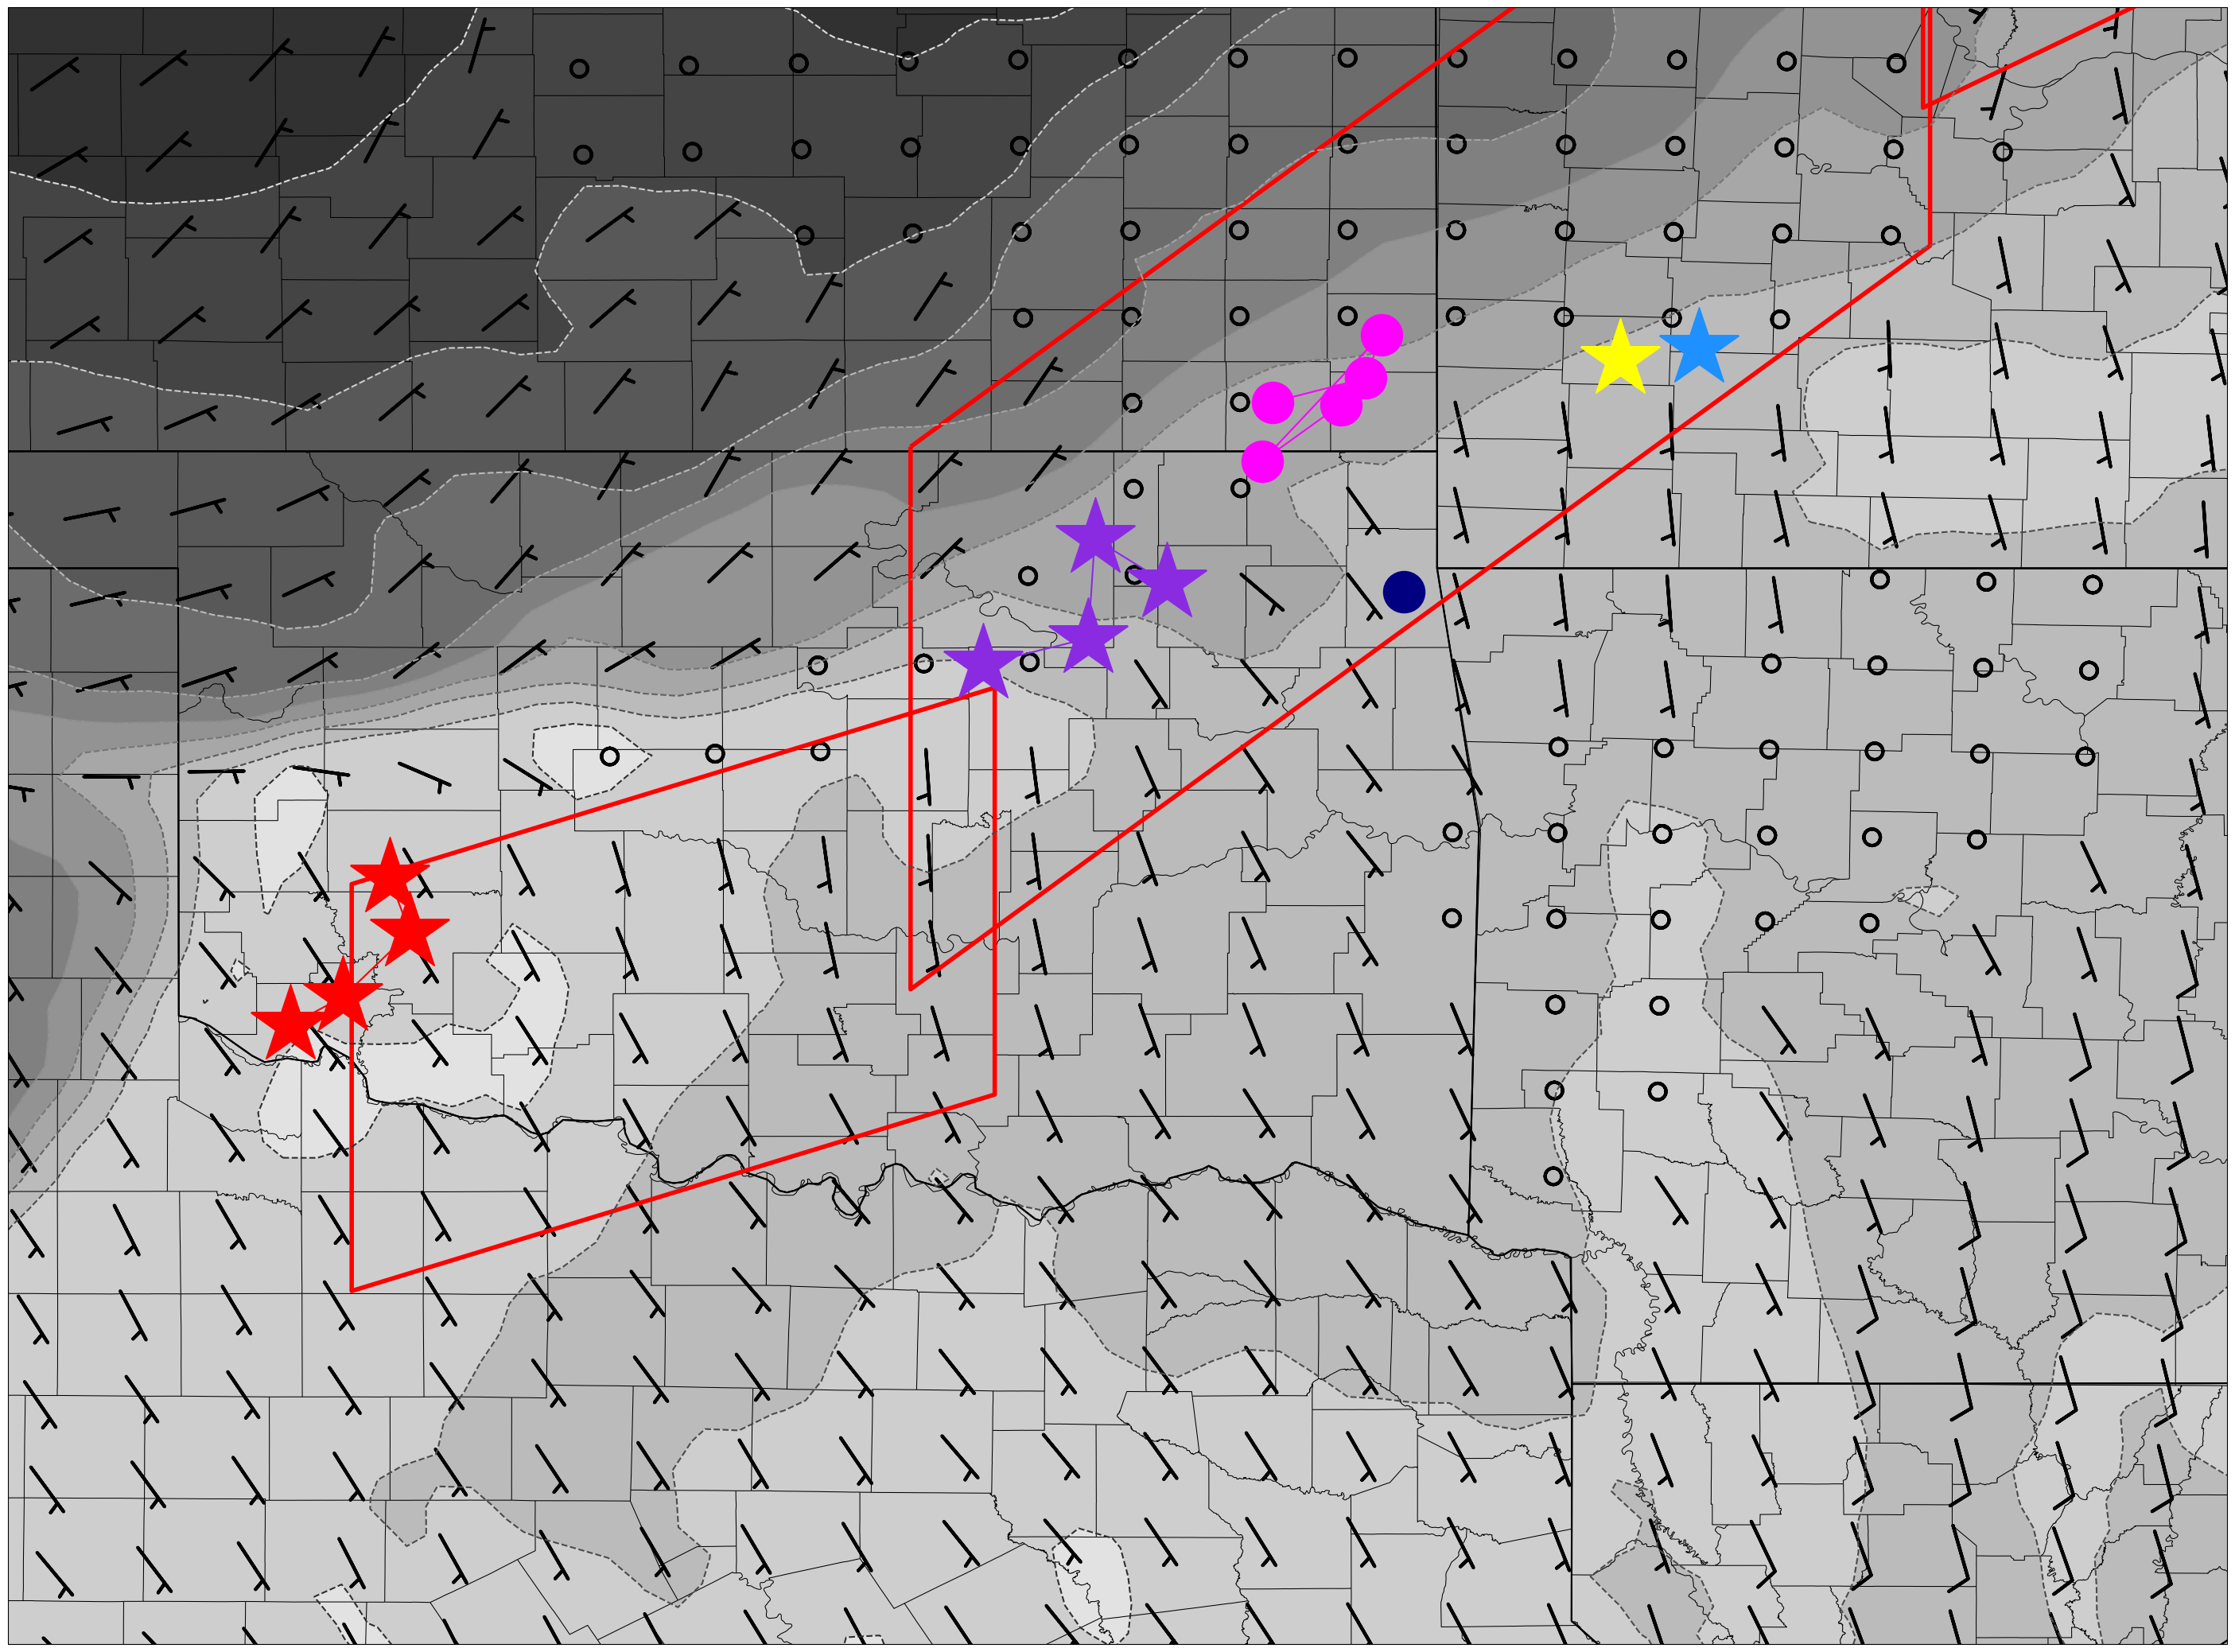

In [83]:
year=2019
month=5
day = 23
hour = 3
Hour = hour

time_start = datetime(int(year), int(month), int(day), int(hour), 0) # Our specified time
hour = time_start.hour
if hour < 10:
    hour = '0'+str(hour)
day = time_start.day
if day < 10:
    day = '0'+str(day)
month = time_start.month
if month < 10:
    month = '0'+str(month)

#ds = xr.open_dataset('https://thredds.ucar.edu/thredds/dodsC/casestudies/python-gallery/NAM_20161031_1200.nc').metpy.parse_cf()
#cat = TDSCatalog('https://www.ncdc.noaa.gov/thredds/catalog/model-rap130-old/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/catalog.html?dataset=rap130-old/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/rap_130_'+str(time_start.year)+str(month)+str(day)+'_'+str(hour)+'00_000.grb2')

#======
file = 0

## 1    
if file == 0:
    try:
        cat = TDSCatalog('https://www.ncei.noaa.gov/thredds/catalog/model-rap130anl-old/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/catalog.html?dataset=rap130anl-old/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/rap_130_'+str(time_start.year)+str(month)+str(day)+'_'+str(hour)+'00_000.grb2')
        file = 1
        print("We have the file we need1!")
    except:
        file = 0
        print("No file yet...")

## 2
if file == 0:
    try:
        cat = TDSCatalog('https://www.ncei.noaa.gov/thredds/catalog/model-ruc130anl-old/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/catalog.html?dataset=ruc130anl-old/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/ruc_130_'+str(time_start.year)+str(month)+str(day)+'_'+str(hour)+'00_000.grb2')
        file = 1
        print("We have the file we need2!")
    except:
        file = 0
        print("No file yet...")
        
## 3
if file == 0:
    try:
        cat = TDSCatalog('https://www.ncei.noaa.gov/thredds/catalog/model-rap252anl-old/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/catalog.html?dataset=rap252anl-old/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/rap_252_'+str(time_start.year)+str(month)+str(day)+'_'+str(hour)+'00_000.grb2')
        file = 1
        print("We have the file we need3!")
    except:
        file = 0
        print("No file yet...")

## 4
if file == 0:
    try:
        cat = TDSCatalog('https://www.ncei.noaa.gov/thredds/catalog/model-ruc252anl-old/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/catalog.html?dataset=ruc252anl-old/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/ruc_252_'+str(time_start.year)+str(month)+str(day)+'_'+str(hour)+'00_000.grb2')
        file = 1
        print("We have the file we need4!")
    except:
        file = 0
        print("No file yet...")        
        
## 1b
if file == 0:
    try:
        cat = TDSCatalog('https://www.ncei.noaa.gov/thredds/catalog/model-rap130anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/catalog.html?dataset=rap130anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/rap_130_'+str(time_start.year)+str(month)+str(day)+'_'+str(hour)+'00_000.grb2')
        file = 1
        print("We have the file we need1b!")
    except:
        file = 0
        print("No file yet...")

## 2b
if file == 0:
    try:
        cat = TDSCatalog('https://www.ncei.noaa.gov/thredds/catalog/model-ruc130anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/catalog.html?dataset=ruc130anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/ruc_130_'+str(time_start.year)+str(month)+str(day)+'_'+str(hour)+'00_000.grb2')
        file = 1
        print("We have the file we need2b!")
    except:
        file = 0
        print("No file yet...")
        
## 3b
if file == 0:
    try:
        cat = TDSCatalog('https://www.ncei.noaa.gov/thredds/catalog/model-rap252anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/catalog.html?dataset=rap252anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/rap_252_'+str(time_start.year)+str(month)+str(day)+'_'+str(hour)+'00_000.grb2')
        file = 1
        print("We have the file we need3b!")
    except:
        file = 0
        print("No file yet...")

## 4b
if file == 0:
    try:
        cat = TDSCatalog('https://www.ncei.noaa.gov/thredds/catalog/model-ruc252anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/catalog.html?dataset=ruc252anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/ruc_252_'+str(time_start.year)+str(month)+str(day)+'_'+str(hour)+'00_000.grb2')
        file = 1
        print("We have the file we need4b!")
    except:
        file = 0
        print("No file yet...")


## 5
#if file == 0:
#    try:
#        cat = TDSCatalog('https://www.ncdc.noaa.gov/thredds/catalog/model-rap130anl-old/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/catalog.html?dataset=rap130anl-old/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/rap_130_'+str(time_start.year)+str(month)+str(day)+'_'+str(hour)+'00_000.grb2')
#        file = 1
#        print("We have the file we need!")
#    except:
#        file = 0
#        print("No file yet...")
        
## 6
#if file == 0:
#    try:
#        cat = TDSCatalog('https://www.ncdc.noaa.gov/thredds/catalog/model-rap130anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/catalog.html?dataset=rap130anl-old/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/rap_130_'+str(time_start.year)+str(month)+str(day)+'_'+str(hour)+'00_000.grb2')
#        file = 1
#        print("We have the file we need...rap130anal!")
#    except:
#        file = 0
#        print("No file yet...rap130anal")

## 7
#if file == 0:
#    try:
#        cat = TDSCatalog('https://www.ncdc.noaa.gov/thredds/catalog/model-rap252anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/catalog.html?dataset=rap130anl-old/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/rap_130_'+str(time_start.year)+str(month)+str(day)+'_'+str(hour)+'00_000.grb2')
#        file = 1
#        print("We have the file we need...rap252anal!")
#    except:
#        file = 0
#        print("No file yet...rap252anal")

## 8
#if file == 0:
#    try:
#        cat = TDSCatalog('https://www.ncei.noaa.gov/thredds/catalog/model-rap130anl-old/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/catalog.html?dataset=rap130anl-old/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/rap_130_'+str(time_start.year)+str(month)+str(day)+'_'+str(hour)+'00_000.grb2')
#        file = 1
#        print("We have the file we need!")
#    except:
#        file = 0
#        print("No file yet...")


## 9
if file == 0:
    try:
        cat = TDSCatalog('http://nomads.ncdc.noaa.gov/thredds/catalog/rap130/'+str(time_start.year)+'0'+str(time_start.month)+'/'+str(time_start.year)+'0'+str(time_start.month)+str(time_start.day)+'/catalog.html?dataset=rap130/'+str(time_start.year)+'0'+str(time_start.month)+'/'+str(time_start.year)+'0'+str(time_start.month)+str(time_start.day)+'/rap_130_'+str(time_start.year)+'0'+str(time_start.month)+str(time_start.day)+'_'+str(time_start.hour)+'00_001.grb2')
        file = 1
        print("We have the file we need!")
    except:
        file = 0
        print("No file yet...")

## 10
if file == 0:
    try:
        cat = TDSCatalog('http://nomads.ncdc.noaa.gov/thredds/catalog/rap130/'+str(year)+str(month)+'/'+str(year)+str(month)+str(day)+'/catalog.html?dataset=rap130/'+str(year)+str(month)+'/'+str(year)+str(month)+str(day)+'/rap_130_'+str(year)+str(month)+str(day)+'_'+str(UTC)+'_000.grb2')
        file = 1
        print("We have the file we need!")
    except:
        file = 0
        print("No file yet...")

## 11
if file == 0:
    try:
        cat = TDSCatalog('https://www.ncei.noaa.gov/thredds/catalog/rap130anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/catalog.html?dataset=rap130anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/rap_130_'+str(time_start.year)+str(month)+str(day)+'_'+str(hour)+'00_000.grb2')
        file = 1
        print("We have the file we need!")
    except:
        file = 0
        print("No file yet...")

## 12
if file == 0:
    try:
        cat = TDSCatalog('https://www.ncdc.noaa.gov/thredds/catalog/model-rap252anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/catalog.html?dataset=rap252anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/rap_252_'+str(time_start.year)+str(month)+str(day)+'_'+str(hour)+'00_000.grb2')
        file = 1
        print("We have the file we need!")
    except:
        file = 0
        print("No file yet...")

## 13
#if file == 0:
#    try:
#        cat = TDSCatalog('https://www.ncei.noaa.gov/thredds/catalog/model-rap252anl-old/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/catalog.html?dataset=rap252anl-old/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/rap_252_'+str(time_start.year)+str(month)+str(day)+'_'+str(hour)+'00_000.grb2') 
#        file = 1
#        print("We have the file we need!")
#    except:
#        file = 0
#        print("No file yet...")

## 14
if file == 0:
    try:
        cat = TDSCatalog('https://www.ncei.noaa.gov/thredds/catalog/model-ruc130anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/catalog.html?dataset=ruc130anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/ruc2anl_130_'+str(time_start.year)+str(month)+str(day)+'_'+str(hour)+'00_000.grb2') 
        file = 1
        print("We have the file we need!")
    except:
        file = 0
        print("No file yet...")

## 15
if file == 0:
    try:
        cat = TDSCatalog('https://www.ncei.noaa.gov/thredds/catalog/model-ruc252anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/catalog.html?dataset=ruc252anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/ruc2anl_252_'+str(time_start.year)+str(month)+str(day)+'_'+str(hour)+'00_000.grb2')
        file = 1
        print("We have the file we need!")
    except:
        file = 0
        print("We didn't get any file!")


latest_ds = list(cat.datasets.values())[0]
#print(latest_ds.access_urls)
ncss = NCSS(latest_ds.access_urls['NetcdfSubset'])
query = ncss.query()
query.variables('Vertical_velocity_pressure_isobaric').variables('Convective_available_potential_energy_surface').variables('u-component_of_wind_isobaric').variables('v-component_of_wind_isobaric').variables('Storm_relative_helicity_height_above_ground_layer').variables('Pressure_surface').variables('Dewpoint_temperature_height_above_ground').variables('Temperature_height_above_ground').variables('Vertical_u-component_shear_height_above_ground_layer').variables('Vertical_v-component_shear_height_above_ground_layer').variables('Geopotential_height_isobaric').variables('Geopotential_height_surface').variables('u-component_of_wind_height_above_ground').variables('v-component_of_wind_height_above_ground').variables('Relative_humidity_isobaric').variables('Temperature_isobaric').variables('Composite_reflectivity_entire_atmosphere')
data1 = ncss.get_data(query)

dtime = data1.variables['Geopotential_height_isobaric'].dimensions[0]
dlev = data1.variables['Geopotential_height_isobaric'].dimensions[1]
dlat = data1.variables['Geopotential_height_isobaric'].dimensions[2] #y
dlon = data1.variables['Geopotential_height_isobaric'].dimensions[3] #x

lats_r = data1.variables[dlat][:]
lons_r= data1.variables[dlon][:]
lev = (np.asarray(data1.variables[dlev][:])/100.) * units('hPa')

# Set up our array of latitude and longitude values and transform to the desired projection.
crs = ccrs.PlateCarree()
crlons, crlats = np.meshgrid(lons_r[:]*1000, lats_r[:]*1000)
trlatlons = crs.transform_points(ccrs.LambertConformal(central_longitude=-95, central_latitude=25),crlons,crlats)
trlons = trlatlons[:,:,0]
trlats = trlatlons[:,:,1]

SFCP = (np.asarray(data1.variables['Pressure_surface'][:])/100.) * units('hPa')
Td = (np.asarray(data1.variables['Dewpoint_temperature_height_above_ground'][:]) * units('kelvin')).to('degC')
T = np.asarray(data1.variables['Temperature_height_above_ground'][:]) * units('kelvin')
hgt = np.asarray(data1.variables['Geopotential_height_isobaric'][:]) * units('meter')
sfc_hgt = np.asarray(data1.variables['Geopotential_height_surface'][:]) * units('meter')
uwnd = np.asarray(data1.variables['u-component_of_wind_isobaric'][:]) * units('m/s')
vwnd = np.asarray(data1.variables['v-component_of_wind_isobaric'][:]) * units('m/s')
Temp_up = np.asarray(data1.variables['Temperature_isobaric'][:]) * units('kelvin')
VVEL_up = np.asarray(data1.variables['Vertical_velocity_pressure_isobaric'][:]) * units('Pa/s')
RH_up = np.asarray(data1.variables['Relative_humidity_isobaric'][:])
usfc = np.asarray(data1.variables['u-component_of_wind_height_above_ground'][:]) * units('m/s')
vsfc = np.asarray(data1.variables['v-component_of_wind_height_above_ground'][:]) * units('m/s')
COMP = data1.variables['Composite_reflectivity_entire_atmosphere'][:]

theta_e = equivalent_potential_temperature(SFCP, T, Td)

reader = shpreader.Reader(r"C:\Users\kyled\Desktop\Thesis GIS Data\County1010\countyl010g.shp")
counties = list(reader.geometries())
COUNTIES = cfeature.ShapelyFeature(counties, ccrs.PlateCarree())

reader1 = shpreader.Reader(r"C:\Users\kyled\Desktop\Thesis GIS Data\watches_201905221800_201905222232\watches_201905221800_201905222232.shp")
watchboxes = list(reader1.geometries())
WATCHES = cfeature.ShapelyFeature(watchboxes, ccrs.PlateCarree())

proj = ccrs.PlateCarree()

fig=plt.figure(figsize = (36,36))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.STATES.with_scale('50m'), linestyle='-', edgecolor='black', linewidth=1.5)
ax.add_feature(COUNTIES, facecolor='none', edgecolor='black', linewidth=0.75)
ax.add_feature(WATCHES, facecolor='none', edgecolor='red', linewidth=4.0)
#ax.set_extent([-104, -93, 32, 39])
#ax.set_extent([-101, -91, 32.25,39.25])
ax.set_extent([-100.73, -91.24, 31.9, 38.9])

# Set attributes for plotting wind barbs
#ax.barbs(x = trlons[::2], y = trlats[::2], u = uwnd[0][2][::2], v = vwnd[0][2][::2], length=8,linewidth=0.6)
#ax.barbs(x = trlons, y = trlats, u = uwnd[0][2], v = vwnd[0][2], length=8,linewidth=0.6)
#ax.barbs(x = trlons[::1], y = trlats[::1], u = uwnd[0][2][::1], v = vwnd[0][2][::1], length=10,linewidth=0.6)

TdF = Td.to('degF')
#cf = ax.contourf(trlons, trlats, TdF[0][0], range(55,80, 1), cmap="YlGn") # Make a filled contour plot
#cf1 = ax.contour(trlons, trlats, TdF[0][0], range(55,80, 1), cmap="inferno") # Make a filled contour plot
cf = ax.contour(trlons, trlats, theta_e[0][0], range(300,370, 5), linestyles='dashed', cmap="Greys", linewidth=1.5) # Make a filled contour plot
cf1 = ax.contourf(trlons, trlats, theta_e[0][0], range(300,370, 5), cmap="gray") # Make a filled contour plot

#cmap = radar_colormap()
#cmap1 = plt.get_cmap(ctables.REF_pmarsh)
#ref_table = truncate_colormap(cmap1, 0, 1)
#cf1 = ax.contourf(trlons, trlats, COMP[0], range(20,70, 2), cmap=ref_table) # Make a filled contour plot


#cf = ax.contourf(trlons, trlats, RH_up[0][36], range(50,105, 5), cmap="YlGn") # Make a filled contour plot
#ax.barbs(x = trlons[::3], y = trlats[::3], u = uwnd[0][36][::3], v = vwnd[0][36][::3], length=8,linewidth=1.5, color='black')

#ax.barbs(x = trlons[::3,::3], y = trlats[::3,::3], u = uwnd[0][36][::3,::3], v = vwnd[0][36][::3,::3], length=14,linewidth=3.5, color='black')
ax.barbs(x = trlons[::3,::3], y = trlats[::3,::3], u = uwnd[0][36][::3,::3], v = vwnd[0][36][::3,::3], length=10,linewidth=3.0, color='black')


#ax.barbs(x = trlons[::2], y = trlats[::2], u = uwnd[0][36][::2], v = vwnd[0][36][::2], length=10,linewidth=0.6, color='green')
#ax.barbs(x = trlons[::2], y = trlats[::2], u = uwnd[0][35][::2], v = vwnd[0][35][::2], length=10,linewidth=0.6, color='green')
#ax.barbs(x = trlons[::2], y = trlats[::2], u = uwnd[0][30][::2], v = vwnd[0][30][::2], length=10,linewidth=0.6, color='red')
#ax.plot(x_values20_, y_values20_, color='green', marker='*', markersize = 25)

#csv23z = pd.read_csv('C:/Users/kyled/Desktop/NI_Points_CSVs/HourlyCSVs/19z.csv', usecols=['StormID', 'Lat', 'Lon', 'Boundary'])
#csv23z = pd.read_csv('C:/Users/kyled/Desktop/NI_Points_CSVs/HourlyCSVs/4z.csv', usecols=['StormID', 'Lat', 'Lon', 'Boundary'])
#x_values23 = [csv23z['Lon'][:]]
#y_values23 = [csv23z['Lat'][:]]
#ax.plot(x_values23, y_values23, color='cyan', marker='*', markersize = 45)
#sns.kdeplot(data=csv23z, x="Lon", y="Lat", hue="Boundary", bw_method='silverman', multiple = "stack", common_grid=False, common_norm=True, fill=True, levels=5, thresh=.4)
#sns.kdeplot(data=csv23z, x="Lon", y="Lat", hue="Boundary", bw_method='scott', multiple = "stack", common_grid=False, common_norm=True, fill=False, levels=5, thresh=.4)


df1 = pd.read_csv("C:/Users/kyled/Desktop/NI_Points_CSVs/5_22_VerticalProfs_QC.csv")
markersize = 75

df = df1[df1.Grouping==1][df1.Time==Hour]
x = df.Lon
y = df.Lat
ax.plot(x, y, color='red', marker='*', markersize = markersize)

df = df1[df1.Grouping==2][df1.Time==Hour]
x = df.Lon
y = df.Lat
ax.plot(x, y, color='darkorange', marker='.', markersize = markersize)

df = df1[df1.Grouping==3][df1.Time==Hour]
x = df.Lon
y = df.Lat
ax.plot(x, y, color='yellow', marker='*', markersize = markersize)

df = df1[df1.Grouping==4][df1.Time==Hour]
x = df.Lon
y = df.Lat
ax.plot(x, y, color='lawngreen', marker='.', markersize = markersize)

df = df1[df1.Grouping==5][df1.Time==Hour]
x = df.Lon
y = df.Lat
ax.plot(x, y, color='turquoise', marker='*', markersize = markersize)

df = df1[df1.Grouping==6][df1.Time==Hour]
x = df.Lon
y = df.Lat
ax.plot(x, y, color='cyan', marker='.', markersize = markersize)

df = df1[df1.Grouping==7][df1.Time==Hour]
x = df.Lon
y = df.Lat
ax.plot(x, y, color='dodgerblue', marker='*', markersize = markersize)

df = df1[df1.Grouping==8][df1.Time==Hour]
x = df.Lon
y = df.Lat
ax.plot(x, y, color='navy', marker='.', markersize = markersize)

df = df1[df1.Grouping==9][df1.Time==Hour]
x = df.Lon
y = df.Lat
ax.plot(x, y, color='blueviolet', marker='*', markersize = markersize)

df = df1[df1.Grouping==10][df1.Time==Hour]
x = df.Lon
y = df.Lat
ax.plot(x, y, color='magenta', marker='.', markersize = markersize)

df = df1[df1.Grouping==11][df1.Time==Hour]
x = df.Lon
y = df.Lat
ax.plot(x, y, color='red', marker='*', markersize = markersize)

df = df1[df1.Grouping==12][df1.Time==Hour]
x = df.Lon
y = df.Lat
ax.plot(x, y, color='orange', marker='.', markersize = markersize)

df = df1[df1.Grouping==13][df1.Time==Hour]
x = df.Lon
y = df.Lat
ax.plot(x, y, color='yellow', marker='*', markersize = markersize)


#scatter = plt.scatter(x,y, c=df.Grouping,cmap='hsv',marker='*', s=1000)

#csv22z_DL = pd.read_csv('C:/Users/kyled/Desktop/NI_Points_CSVs/HourlyCSVs/23z_DL.csv')
#csv22z_DL = pd.read_csv('C:/Users/kyled/Desktop/NI_Points_CSVs/HourlyCSVs/19z.csv', usecols=['StormID', 'Lat', 'Lon', 'Initiation'])
#x_values22z_DL = [csv22z_DL['Lon'][:]]
#y_values22z_DL = [csv22z_DL['Lat'][:]]
#ax.plot(x_values22z_DL, y_values22z_DL, color='cyan', marker='*', markersize = 100)
#sns.kdeplot(data=csv23z, x="Lon", y="Lat", hue="Boundary", fill=True, levels=5, thresh=.4)
#sns.kdeplot(data=csv23z, x="Lon", y="Lat", hue="Initiation", fill=True)
#positions = np.vstack([x_values22z_DL, y_values22z_DL])
#values22z_DL = np.vstack([x_values22z_DL,y_values22z_DL])
#kernel = stats.gaussian_kde(values)
#DL_22z = sns.load_dataset('C:/Users/kyled/Desktop/NI_Points_CSVs/HourlyCSVs/22z_DL.csv')
#sns.kdeplot(data=csv22z_DL, x="Lon", y="Lat", fill=False, thresh=.1)

#scatter = plt.scatter(x_values22z_DL, y_values22z_DL, c=csv22z_DL.MaxProfiles,cmap='viridis',marker='*', s=1000)
#plt.plot(x_values22z_DL, y_values22z_DL, c=csv22z_DL.MaxProfiles.astype(int),cmap='viridis',marker='*', markersize=100)
#plt.figlegend(scatter,loc='lower right')

#sns.relplot(data=csv22z_DL, x='Lon', y='Lat', hue='MaxProfiles', palette='tab10', kind='scatter')

#csv22z_OP = pd.read_csv('C:/Users/kyled/Desktop/NI_Points_CSVs/HourlyCSVs/23z_OP.csv', usecols=['StormID', 'Lat', 'Lon', 'Initiation'])
#x_values22z_OP = [csv22z_OP['Lon'][:]]
#y_values22z_OP = [csv22z_OP['Lat'][:]]
#ax.plot(x_values22z_OP, y_values22z_OP, color='lime', marker='*', markersize = 100)
#sns.kdeplot(data=csv23z, x="Lon", y="Lat", hue="Boundary", fill=True, levels=5, thresh=.4)
#sns.kdeplot(data=csv23z, x="Lon", y="Lat", hue="Initiation", fill=True)
#sns.kdeplot(data=csv22z_OP, x="Lon", y="Lat", fill=False, thresh=.1)

#csv22z_WF = pd.read_csv('C:/Users/kyled/Desktop/NI_Points_CSVs/HourlyCSVs/23z_WF.csv', usecols=['StormID', 'Lat', 'Lon', 'Initiation'])
#x_values22z_WF = [csv22z_WF['Lon'][:]]
#y_values22z_WF = [csv22z_WF['Lat'][:]]
#ax.plot(x_values22z_WF, y_values22z_WF, color='orange', marker='*', markersize = 100)
#sns.kdeplot(data=csv23z, x="Lon", y="Lat", hue="Boundary", fill=True, levels=5, thresh=.4)
#sns.kdeplot(data=csv23z, x="Lon", y="Lat", hue="Initiation", fill=True)
#sns.kdeplot(data=csv22z_WF, x="Lon", y="Lat", fill=False, thresh=.1)

#plt.title('RAP Surface Winds and Surface Dewpoint(\N{DEGREE SIGN}F) '+str(year)+str(month)+str(day)+'_'+str(hour)+'z', fontsize=36)
#plt.title('RAP Surface Winds and 'r'$\theta$e '+str(year)+str(month)+str(day)+'_'+str(hour)+'z', fontsize=36)
#plt.title('RAP surface [+1] winds '+str(year)+str(month)+str(day)+'_'+str(hour)+'z', fontsize=36)
#plt.title('RAP surface winds (black) & 850 mb (red) winds '+str(year)+str(month)+str(day)+'_'+str(hour)+'z', fontsize=36)
#plt.colorbar(cf, extend='max', aspect=75, shrink=0.55, pad=0.01,extendrect='True')
#cbar = plt.colorbar(cf1, shrink=0.55, pad=0.01)
#cbar.ax.tick_params(labelsize=20) 

plt.savefig(r"C:\Users\kyled\Desktop\GroupMaps\Groupings_"+str(year)+str(month)+str(day)+"_"+str(hour)+"z.png", bbox_inches='tight')
#plt.savefig(r"C:\Users\kyled\Desktop\RAP 5-22 Wind Plots\RAP surface [+1] winds "+str(year)+str(month)+str(day)+"_"+str(hour)+"z.png")
#plt.savefig(r"C:\Users\kyled\Desktop\RAP 5-22 Wind Plots\RAP surface winds "+str(year)+str(month)+str(day)+"_"+str(hour)+"z.png")
#plt.savefig(r"C:\Users\kyled\Desktop\RAP 5-22 Wind Plots\RAP surface and 850 winds "+str(year)+str(month)+str(day)+"_"+str(hour)+"z.png")
#plt.savefig(r"C:\Users\kyled\Desktop\RAP 5-22 Wind Plots\RAP Dewpoint and surface winds "+str(year)+str(month)+str(day)+"_"+str(hour)+"z.png")
#plt.savefig(r"C:\Users\kyled\Desktop\GroupMaps\RAP 5-22 Wind Plots\RAP Dewpoint and surface winds "+str(year)+str(month)+str(day)+"_"+str(hour)+"z.png")

#print(np.amax(theta_e))
#print(np.amin(theta_e))
#plt.switch_backend('Agg')
plt.show()
#plt.imshow(SFCP[0])
#plt.colorbar()

In [51]:
print(ref_table)

In [88]:
df1 = pd.read_csv("C:/Users/kyled/Desktop/NI_Points_CSVs/5_22_VerticalProfs(NewJuly2022)_QC_wDataNo109.csv")
for i in df1.Grouping.unique():
    print(i)

7
9
2
8
10
6
5
4
1
3
11
13
15
12
14


In [207]:
df1 = pd.read_csv("C:/Users/kyled/Desktop/NI_Points_CSVs/5_22_VerticalProfs_QC.csv")
df = df1[df1.Grouping==6][df1.SupercellAny=="Y"]
x = df.Lon
y = df.Lat
#ax.plot(x, y, color='blueviolet', marker='*', markersize = markersize
print(df)

    StormID  Time  Grouping  HrSequence  Time_3  Time_6  Time_12  Start   End  \
138      41    23         6           4      20      17       11    xxx   xxx   
139      41    22         6           3      19      16       10  21:51  0:13   
140      41     0         6           5      21      18       12    xxx   xxx   
141      10    23         6           4      20      17       11    xxx   xxx   
142      10    22         6           3      19      16       10  21:59  1:27   
143      10     1         6           6      22      19       13    xxx   xxx   
144      10     0         6           5      21      18       12    xxx   xxx   

     Life (in mins)  ... ObservedRM ObservedRMAngle Bunkers_RMU Bunkers_RMV  \
138             142  ...  14.375484       48.674978    4.807725    5.596988   
139             142  ...   8.116465       76.150532    4.942014    5.601759   
140             142  ...  15.642984       44.746971    4.061143    5.005539   
141             208  ...  11.811789

C:\Users\kyled\AppData\Local\Temp\ipykernel_13376\2711064002.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df1[df1.Grouping==6][df1.SupercellAny=="Y"]


In [ ]:
csv18_19 = pd.read_csv('C:/Users/kyled/Desktop/CellTrackingCSV/TimeSplits/18_19.csv', usecols=['StormID', 'Start', 'End', 'Life (in mins)', 'Rounded Time (mins)', 'Demise', 'Radar', 'Ini_Lat', 'Ini_Lon', 'Ini_Time', 'Lat_2', 'Lon_2', 'Time_2'])
csv19_20 = pd.read_csv('C:/Users/kyled/Desktop/CellTrackingCSV/TimeSplits/19_20.csv', usecols=['StormID', 'Start', 'End', 'Life (in mins)', 'Rounded Time (mins)', 'Demise', 'Radar', 'Ini_Lat', 'Ini_Lon', 'Ini_Time', 'Lat_2', 'Lon_2', 'Time_2'])
csv20_21 = pd.read_csv('C:/Users/kyled/Desktop/CellTrackingCSV/TimeSplits/20_21.csv', usecols=['StormID', 'Start', 'End', 'Life (in mins)', 'Rounded Time (mins)', 'Demise', 'Radar', 'Ini_Lat', 'Ini_Lon', 'Ini_Time', 'Lat_2', 'Lon_2', 'Time_2'])
csv21_22 = pd.read_csv('C:/Users/kyled/Desktop/CellTrackingCSV/TimeSplits/21_22.csv', usecols=['StormID', 'Start', 'End', 'Life (in mins)', 'Rounded Time (mins)', 'Demise', 'Radar', 'Ini_Lat', 'Ini_Lon', 'Ini_Time', 'Lat_2', 'Lon_2', 'Time_2'])
csv22_23 = pd.read_csv('C:/Users/kyled/Desktop/CellTrackingCSV/TimeSplits/22_23.csv', usecols=['StormID', 'Start', 'End', 'Life (in mins)', 'Rounded Time (mins)', 'Demise', 'Radar', 'Ini_Lat', 'Ini_Lon', 'Ini_Time', 'Lat_2', 'Lon_2', 'Time_2'])
csv23_0 = pd.read_csv('C:/Users/kyled/Desktop/CellTrackingCSV/TimeSplits/23_0.csv', usecols=['StormID', 'Start', 'End', 'Life (in mins)', 'Rounded Time (mins)', 'Demise', 'Radar', 'Ini_Lat', 'Ini_Lon', 'Ini_Time', 'Lat_2', 'Lon_2', 'Time_2'])
csv00_01 = pd.read_csv('C:/Users/kyled/Desktop/CellTrackingCSV/TimeSplits/00_01.csv', usecols=['StormID', 'Start', 'End', 'Life (in mins)', 'Rounded Time (mins)', 'Demise', 'Radar', 'Ini_Lat', 'Ini_Lon', 'Ini_Time', 'Lat_2', 'Lon_2', 'Time_2'])
csv01_02 = pd.read_csv('C:/Users/kyled/Desktop/CellTrackingCSV/TimeSplits/01_02.csv', usecols=['StormID', 'Start', 'End', 'Life (in mins)', 'Rounded Time (mins)', 'Demise', 'Radar', 'Ini_Lat', 'Ini_Lon', 'Ini_Time', 'Lat_2', 'Lon_2', 'Time_2'])
csv02_03 = pd.read_csv('C:/Users/kyled/Desktop/CellTrackingCSV/TimeSplits/02_03.csv', usecols=['StormID', 'Start', 'End', 'Life (in mins)', 'Rounded Time (mins)', 'Demise', 'Radar', 'Ini_Lat', 'Ini_Lon', 'Ini_Time', 'Lat_2', 'Lon_2', 'Time_2'])
csv03_04 = pd.read_csv('C:/Users/kyled/Desktop/CellTrackingCSV/TimeSplits/03_04.csv', usecols=['StormID', 'Start', 'End', 'Life (in mins)', 'Rounded Time (mins)', 'Demise', 'Radar', 'Ini_Lat', 'Ini_Lon', 'Ini_Time', 'Lat_2', 'Lon_2', 'Time_2'])
csv04_05 = pd.read_csv('C:/Users/kyled/Desktop/CellTrackingCSV/TimeSplits/04_05.csv', usecols=['StormID', 'Start', 'End', 'Life (in mins)', 'Rounded Time (mins)', 'Demise', 'Radar', 'Ini_Lat', 'Ini_Lon', 'Ini_Time', 'Lat_2', 'Lon_2', 'Time_2'])
csv05_06 = pd.read_csv('C:/Users/kyled/Desktop/CellTrackingCSV/TimeSplits/05_06.csv', usecols=['StormID', 'Start', 'End', 'Life (in mins)', 'Rounded Time (mins)', 'Demise', 'Radar', 'Ini_Lat', 'Ini_Lon', 'Ini_Time', 'Lat_2', 'Lon_2', 'Time_2'])
csv06_07 = pd.read_csv('C:/Users/kyled/Desktop/CellTrackingCSV/TimeSplits/06_07.csv', usecols=['StormID', 'Start', 'End', 'Life (in mins)', 'Rounded Time (mins)', 'Demise', 'Radar', 'Ini_Lat', 'Ini_Lon', 'Ini_Time', 'Lat_2', 'Lon_2', 'Time_2'])
csv07_08 = pd.read_csv('C:/Users/kyled/Desktop/CellTrackingCSV/TimeSplits/07_08.csv', usecols=['StormID', 'Start', 'End', 'Life (in mins)', 'Rounded Time (mins)', 'Demise', 'Radar', 'Ini_Lat', 'Ini_Lon', 'Ini_Time', 'Lat_2', 'Lon_2', 'Time_2'])

csv19_20_Supercell = pd.read_csv('C:/Users/kyled/Desktop/CellTrackingCSV/TimeSplits/19_20_Supercell.csv', usecols=['StormID', 'Start', 'End', 'Life (in mins)', 'Rounded Time (mins)', 'Demise', 'Radar', 'Ini_Lat', 'Ini_Lon', 'Ini_Time', 'Lat_2', 'Lon_2', 'Time_2'])
csv20_21_Supercell = pd.read_csv('C:/Users/kyled/Desktop/CellTrackingCSV/TimeSplits/20_21_Supercell.csv', usecols=['StormID', 'Start', 'End', 'Life (in mins)', 'Rounded Time (mins)', 'Demise', 'Radar', 'Ini_Lat', 'Ini_Lon', 'Ini_Time', 'Lat_2', 'Lon_2', 'Time_2'])
csv21_22_Supercell = pd.read_csv('C:/Users/kyled/Desktop/CellTrackingCSV/TimeSplits/21_22_Supercell.csv', usecols=['StormID', 'Start', 'End', 'Life (in mins)', 'Rounded Time (mins)', 'Demise', 'Radar', 'Ini_Lat', 'Ini_Lon', 'Ini_Time', 'Lat_2', 'Lon_2', 'Time_2'])
csv22_23_Supercell = pd.read_csv('C:/Users/kyled/Desktop/CellTrackingCSV/TimeSplits/22_23_Supercell.csv', usecols=['StormID', 'Start', 'End', 'Life (in mins)', 'Rounded Time (mins)', 'Demise', 'Radar', 'Ini_Lat', 'Ini_Lon', 'Ini_Time', 'Lat_2', 'Lon_2', 'Time_2'])
csv23_0_Supercell = pd.read_csv('C:/Users/kyled/Desktop/CellTrackingCSV/TimeSplits/23_0_Supercell.csv', usecols=['StormID', 'Start', 'End', 'Life (in mins)', 'Rounded Time (mins)', 'Demise', 'Radar', 'Ini_Lat', 'Ini_Lon', 'Ini_Time', 'Lat_2', 'Lon_2', 'Time_2'])
csv00_01_Supercell = pd.read_csv('C:/Users/kyled/Desktop/CellTrackingCSV/TimeSplits/00_01_Supercell.csv', usecols=['StormID', 'Start', 'End', 'Life (in mins)', 'Rounded Time (mins)', 'Demise', 'Radar', 'Ini_Lat', 'Ini_Lon', 'Ini_Time', 'Lat_2', 'Lon_2', 'Time_2'])
csv01_02_Supercell = pd.read_csv('C:/Users/kyled/Desktop/CellTrackingCSV/TimeSplits/01_02_Supercell.csv', usecols=['StormID', 'Start', 'End', 'Life (in mins)', 'Rounded Time (mins)', 'Demise', 'Radar', 'Ini_Lat', 'Ini_Lon', 'Ini_Time', 'Lat_2', 'Lon_2', 'Time_2'])
csv02_03_Supercell = pd.read_csv('C:/Users/kyled/Desktop/CellTrackingCSV/TimeSplits/02_03_Supercell.csv', usecols=['StormID', 'Start', 'End', 'Life (in mins)', 'Rounded Time (mins)', 'Demise', 'Radar', 'Ini_Lat', 'Ini_Lon', 'Ini_Time', 'Lat_2', 'Lon_2', 'Time_2'])
csv03_04_Supercell = pd.read_csv('C:/Users/kyled/Desktop/CellTrackingCSV/TimeSplits/03_04_Supercell.csv', usecols=['StormID', 'Start', 'End', 'Life (in mins)', 'Rounded Time (mins)', 'Demise', 'Radar', 'Ini_Lat', 'Ini_Lon', 'Ini_Time', 'Lat_2', 'Lon_2', 'Time_2'])
csv04_05_Supercell = pd.read_csv('C:/Users/kyled/Desktop/CellTrackingCSV/TimeSplits/04_05_Supercell.csv', usecols=['StormID', 'Start', 'End', 'Life (in mins)', 'Rounded Time (mins)', 'Demise', 'Radar', 'Ini_Lat', 'Ini_Lon', 'Ini_Time', 'Lat_2', 'Lon_2', 'Time_2'])
csv05_06_Supercell = pd.read_csv('C:/Users/kyled/Desktop/CellTrackingCSV/TimeSplits/05_06_Supercell.csv', usecols=['StormID', 'Start', 'End', 'Life (in mins)', 'Rounded Time (mins)', 'Demise', 'Radar', 'Ini_Lat', 'Ini_Lon', 'Ini_Time', 'Lat_2', 'Lon_2', 'Time_2'])
csv06_07_Supercell = pd.read_csv('C:/Users/kyled/Desktop/CellTrackingCSV/TimeSplits/06_07_Supercell.csv', usecols=['StormID', 'Start', 'End', 'Life (in mins)', 'Rounded Time (mins)', 'Demise', 'Radar', 'Ini_Lat', 'Ini_Lon', 'Ini_Time', 'Lat_2', 'Lon_2', 'Time_2'])
csv07_08_Supercell = pd.read_csv('C:/Users/kyled/Desktop/CellTrackingCSV/TimeSplits/07_08_Supercell.csv', usecols=['StormID', 'Start', 'End', 'Life (in mins)', 'Rounded Time (mins)', 'Demise', 'Radar', 'Ini_Lat', 'Ini_Lon', 'Ini_Time', 'Lat_2', 'Lon_2', 'Time_2'])

csv19_20_Tornado = pd.read_csv('C:/Users/kyled/Desktop/CellTrackingCSV/TimeSplits/19_20_Tornado.csv', usecols=['StormID', 'Start', 'End', 'Life (in mins)', 'Rounded Time (mins)', 'Demise', 'Radar', 'Ini_Lat', 'Ini_Lon', 'Ini_Time', 'Lat_2', 'Lon_2', 'Time_2'])
csv20_21_Tornado = pd.read_csv('C:/Users/kyled/Desktop/CellTrackingCSV/TimeSplits/20_21_Tornado.csv', usecols=['StormID', 'Start', 'End', 'Life (in mins)', 'Rounded Time (mins)', 'Demise', 'Radar', 'Ini_Lat', 'Ini_Lon', 'Ini_Time', 'Lat_2', 'Lon_2', 'Time_2'])
csv21_22_Tornado = pd.read_csv('C:/Users/kyled/Desktop/CellTrackingCSV/TimeSplits/21_22_Tornado.csv', usecols=['StormID', 'Start', 'End', 'Life (in mins)', 'Rounded Time (mins)', 'Demise', 'Radar', 'Ini_Lat', 'Ini_Lon', 'Ini_Time', 'Lat_2', 'Lon_2', 'Time_2'])
csv22_23_Tornado = pd.read_csv('C:/Users/kyled/Desktop/CellTrackingCSV/TimeSplits/22_23_Tornado.csv', usecols=['StormID', 'Start', 'End', 'Life (in mins)', 'Rounded Time (mins)', 'Demise', 'Radar', 'Ini_Lat', 'Ini_Lon', 'Ini_Time', 'Lat_2', 'Lon_2', 'Time_2'])
csv23_0_Tornado = pd.read_csv('C:/Users/kyled/Desktop/CellTrackingCSV/TimeSplits/23_0_Tornado.csv', usecols=['StormID', 'Start', 'End', 'Life (in mins)', 'Rounded Time (mins)', 'Demise', 'Radar', 'Ini_Lat', 'Ini_Lon', 'Ini_Time', 'Lat_2', 'Lon_2', 'Time_2'])
csv00_01_Tornado = pd.read_csv('C:/Users/kyled/Desktop/CellTrackingCSV/TimeSplits/00_01_Tornado.csv', usecols=['StormID', 'Start', 'End', 'Life (in mins)', 'Rounded Time (mins)', 'Demise', 'Radar', 'Ini_Lat', 'Ini_Lon', 'Ini_Time', 'Lat_2', 'Lon_2', 'Time_2'])
csv01_02_Tornado = pd.read_csv('C:/Users/kyled/Desktop/CellTrackingCSV/TimeSplits/01_02_Tornado.csv', usecols=['StormID', 'Start', 'End', 'Life (in mins)', 'Rounded Time (mins)', 'Demise', 'Radar', 'Ini_Lat', 'Ini_Lon', 'Ini_Time', 'Lat_2', 'Lon_2', 'Time_2'])
csv02_03_Tornado = pd.read_csv('C:/Users/kyled/Desktop/CellTrackingCSV/TimeSplits/02_03_Tornado.csv', usecols=['StormID', 'Start', 'End', 'Life (in mins)', 'Rounded Time (mins)', 'Demise', 'Radar', 'Ini_Lat', 'Ini_Lon', 'Ini_Time', 'Lat_2', 'Lon_2', 'Time_2'])
csv03_04_Tornado = pd.read_csv('C:/Users/kyled/Desktop/CellTrackingCSV/TimeSplits/03_04_Tornado.csv', usecols=['StormID', 'Start', 'End', 'Life (in mins)', 'Rounded Time (mins)', 'Demise', 'Radar', 'Ini_Lat', 'Ini_Lon', 'Ini_Time', 'Lat_2', 'Lon_2', 'Time_2'])
csv04_05_Tornado = pd.read_csv('C:/Users/kyled/Desktop/CellTrackingCSV/TimeSplits/04_05_Tornado.csv', usecols=['StormID', 'Start', 'End', 'Life (in mins)', 'Rounded Time (mins)', 'Demise', 'Radar', 'Ini_Lat', 'Ini_Lon', 'Ini_Time', 'Lat_2', 'Lon_2', 'Time_2'])
csv05_06_Tornado = pd.read_csv('C:/Users/kyled/Desktop/CellTrackingCSV/TimeSplits/05_06_Tornado.csv', usecols=['StormID', 'Start', 'End', 'Life (in mins)', 'Rounded Time (mins)', 'Demise', 'Radar', 'Ini_Lat', 'Ini_Lon', 'Ini_Time', 'Lat_2', 'Lon_2', 'Time_2'])
csv06_07_Tornado = pd.read_csv('C:/Users/kyled/Desktop/CellTrackingCSV/TimeSplits/06_07_Tornado.csv', usecols=['StormID', 'Start', 'End', 'Life (in mins)', 'Rounded Time (mins)', 'Demise', 'Radar', 'Ini_Lat', 'Ini_Lon', 'Ini_Time', 'Lat_2', 'Lon_2', 'Time_2'])
csv07_08_Tornado = pd.read_csv('C:/Users/kyled/Desktop/CellTrackingCSV/TimeSplits/07_08_Tornado.csv', usecols=['StormID', 'Start', 'End', 'Life (in mins)', 'Rounded Time (mins)', 'Demise', 'Radar', 'Ini_Lat', 'Ini_Lon', 'Ini_Time', 'Lat_2', 'Lon_2', 'Time_2'])

x_values18 = [csv18_19['Ini_Lon'][:], csv18_19['Lon_2'][:]]
y_values18 = [csv18_19['Ini_Lat'][:], csv18_19['Lat_2'][:]]
x_values19 = [csv19_20['Ini_Lon'][:], csv19_20['Lon_2'][:]]
y_values19 = [csv19_20['Ini_Lat'][:], csv19_20['Lat_2'][:]]
x_values20 = [csv20_21['Ini_Lon'][:], csv20_21['Lon_2'][:]]
y_values20 = [csv20_21['Ini_Lat'][:], csv20_21['Lat_2'][:]]
x_values21 = [csv21_22['Ini_Lon'][:], csv21_22['Lon_2'][:]]
y_values21 = [csv21_22['Ini_Lat'][:], csv21_22['Lat_2'][:]]
x_values22 = [csv22_23['Ini_Lon'][:], csv22_23['Lon_2'][:]]
y_values22 = [csv22_23['Ini_Lat'][:], csv22_23['Lat_2'][:]]
x_values23 = [csv23_0['Ini_Lon'][:], csv23_0['Lon_2'][:]]
y_values23 = [csv23_0['Ini_Lat'][:], csv23_0['Lat_2'][:]]
x_values00 = [csv00_01['Ini_Lon'][:], csv00_01['Lon_2'][:]]
y_values00 = [csv00_01['Ini_Lat'][:], csv00_01['Lat_2'][:]]
x_values01 = [csv01_02['Ini_Lon'][:], csv01_02['Lon_2'][:]]
y_values01 = [csv01_02['Ini_Lat'][:], csv01_02['Lat_2'][:]]
x_values02 = [csv02_03['Ini_Lon'][:], csv02_03['Lon_2'][:]]
y_values02 = [csv02_03['Ini_Lat'][:], csv02_03['Lat_2'][:]]
x_values03 = [csv03_04['Ini_Lon'][:], csv03_04['Lon_2'][:]]
y_values03 = [csv03_04['Ini_Lat'][:], csv03_04['Lat_2'][:]]
x_values04 = [csv04_05['Ini_Lon'][:], csv04_05['Lon_2'][:]]
y_values04 = [csv04_05['Ini_Lat'][:], csv04_05['Lat_2'][:]]
x_values05 = [csv05_06['Ini_Lon'][:], csv05_06['Lon_2'][:]]
y_values05 = [csv05_06['Ini_Lat'][:], csv05_06['Lat_2'][:]]
x_values06 = [csv06_07['Ini_Lon'][:], csv06_07['Lon_2'][:]]
y_values06 = [csv06_07['Ini_Lat'][:], csv06_07['Lat_2'][:]]
x_values07 = [csv07_08['Ini_Lon'][:], csv07_08['Lon_2'][:]]
y_values07 = [csv07_08['Ini_Lat'][:], csv07_08['Lat_2'][:]]

x_values19_Supercell = [csv19_20_Supercell['Ini_Lon'][:], csv19_20_Supercell['Lon_2'][:]]
y_values19_Supercell = [csv19_20_Supercell['Ini_Lat'][:], csv19_20_Supercell['Lat_2'][:]]
x_values20_Supercell = [csv20_21_Supercell['Ini_Lon'][:], csv20_21_Supercell['Lon_2'][:]]
y_values20_Supercell = [csv20_21_Supercell['Ini_Lat'][:], csv20_21_Supercell['Lat_2'][:]]
x_values21_Supercell = [csv21_22_Supercell['Ini_Lon'][:], csv21_22_Supercell['Lon_2'][:]]
y_values21_Supercell = [csv21_22_Supercell['Ini_Lat'][:], csv21_22_Supercell['Lat_2'][:]]
x_values22_Supercell = [csv22_23_Supercell['Ini_Lon'][:], csv22_23_Supercell['Lon_2'][:]]
y_values22_Supercell = [csv22_23_Supercell['Ini_Lat'][:], csv22_23_Supercell['Lat_2'][:]]
x_values23_Supercell = [csv23_0_Supercell['Ini_Lon'][:], csv23_0_Supercell['Lon_2'][:]]
y_values23_Supercell = [csv23_0_Supercell['Ini_Lat'][:], csv23_0_Supercell['Lat_2'][:]]
x_values00_Supercell = [csv00_01_Supercell['Ini_Lon'][:], csv00_01_Supercell['Lon_2'][:]]
y_values00_Supercell = [csv00_01_Supercell['Ini_Lat'][:], csv00_01_Supercell['Lat_2'][:]]
x_values01_Supercell = [csv01_02_Supercell['Ini_Lon'][:], csv01_02_Supercell['Lon_2'][:]]
y_values01_Supercell = [csv01_02_Supercell['Ini_Lat'][:], csv01_02_Supercell['Lat_2'][:]]
x_values02_Supercell = [csv02_03_Supercell['Ini_Lon'][:], csv02_03_Supercell['Lon_2'][:]]
y_values02_Supercell = [csv02_03_Supercell['Ini_Lat'][:], csv02_03_Supercell['Lat_2'][:]]
x_values03_Supercell = [csv03_04_Supercell['Ini_Lon'][:], csv03_04_Supercell['Lon_2'][:]]
y_values03_Supercell = [csv03_04_Supercell['Ini_Lat'][:], csv03_04_Supercell['Lat_2'][:]]
x_values04_Supercell = [csv04_05_Supercell['Ini_Lon'][:], csv04_05_Supercell['Lon_2'][:]]
y_values04_Supercell = [csv04_05_Supercell['Ini_Lat'][:], csv04_05_Supercell['Lat_2'][:]]
x_values05_Supercell = [csv05_06_Supercell['Ini_Lon'][:], csv05_06_Supercell['Lon_2'][:]]
y_values05_Supercell = [csv05_06_Supercell['Ini_Lat'][:], csv05_06_Supercell['Lat_2'][:]]
x_values06_Supercell = [csv06_07_Supercell['Ini_Lon'][:], csv06_07_Supercell['Lon_2'][:]]
y_values06_Supercell = [csv06_07_Supercell['Ini_Lat'][:], csv06_07_Supercell['Lat_2'][:]]
x_values07_Supercell = [csv07_08_Supercell['Ini_Lon'][:], csv07_08_Supercell['Lon_2'][:]]
y_values07_Supercell = [csv07_08_Supercell['Ini_Lat'][:], csv07_08_Supercell['Lat_2'][:]]

x_values19_Tornado = [csv19_20_Tornado['Ini_Lon'][:], csv19_20_Tornado['Lon_2'][:]]
y_values19_Tornado = [csv19_20_Tornado['Ini_Lat'][:], csv19_20_Tornado['Lat_2'][:]]
x_values20_Tornado = [csv20_21_Tornado['Ini_Lon'][:], csv20_21_Tornado['Lon_2'][:]]
y_values20_Tornado = [csv20_21_Tornado['Ini_Lat'][:], csv20_21_Tornado['Lat_2'][:]]
x_values21_Tornado = [csv21_22_Tornado['Ini_Lon'][:], csv21_22_Tornado['Lon_2'][:]]
y_values21_Tornado = [csv21_22_Tornado['Ini_Lat'][:], csv21_22_Tornado['Lat_2'][:]]
x_values22_Tornado = [csv22_23_Tornado['Ini_Lon'][:], csv22_23_Tornado['Lon_2'][:]]
y_values22_Tornado = [csv22_23_Tornado['Ini_Lat'][:], csv22_23_Tornado['Lat_2'][:]]
x_values23_Tornado = [csv23_0_Tornado['Ini_Lon'][:], csv23_0_Tornado['Lon_2'][:]]
y_values23_Tornado = [csv23_0_Tornado['Ini_Lat'][:], csv23_0_Tornado['Lat_2'][:]]
x_values00_Tornado = [csv00_01_Tornado['Ini_Lon'][:], csv00_01_Tornado['Lon_2'][:]]
y_values00_Tornado = [csv00_01_Tornado['Ini_Lat'][:], csv00_01_Tornado['Lat_2'][:]]
x_values01_Tornado = [csv01_02_Tornado['Ini_Lon'][:], csv01_02_Tornado['Lon_2'][:]]
y_values01_Tornado = [csv01_02_Tornado['Ini_Lat'][:], csv01_02_Tornado['Lat_2'][:]]
x_values02_Tornado = [csv02_03_Tornado['Ini_Lon'][:], csv02_03_Tornado['Lon_2'][:]]
y_values02_Tornado = [csv02_03_Tornado['Ini_Lat'][:], csv02_03_Tornado['Lat_2'][:]]
x_values03_Tornado = [csv03_04_Tornado['Ini_Lon'][:], csv03_04_Tornado['Lon_2'][:]]
y_values03_Tornado = [csv03_04_Tornado['Ini_Lat'][:], csv03_04_Tornado['Lat_2'][:]]
x_values04_Tornado = [csv04_05_Tornado['Ini_Lon'][:], csv04_05_Tornado['Lon_2'][:]]
y_values04_Tornado = [csv04_05_Tornado['Ini_Lat'][:], csv04_05_Tornado['Lat_2'][:]]
x_values05_Tornado = [csv05_06_Tornado['Ini_Lon'][:], csv05_06_Tornado['Lon_2'][:]]
y_values05_Tornado = [csv05_06_Tornado['Ini_Lat'][:], csv05_06_Tornado['Lat_2'][:]]
x_values06_Tornado = [csv06_07_Tornado['Ini_Lon'][:], csv06_07_Tornado['Lon_2'][:]]
y_values06_Tornado = [csv06_07_Tornado['Ini_Lat'][:], csv06_07_Tornado['Lat_2'][:]]
x_values07_Tornado = [csv07_08_Tornado['Ini_Lon'][:], csv07_08_Tornado['Lon_2'][:]]
y_values07_Tornado = [csv07_08_Tornado['Ini_Lat'][:], csv07_08_Tornado['Lat_2'][:]]

ax.plot(x_values18, y_values18, linestyle="-", color='green', linewidth=1)
ax.plot(x_values19, y_values19, linestyle="-", color='green', linewidth=1)
ax.plot(x_values20, y_values20, linestyle="-", color='green', linewidth=1)
ax.plot(x_values21, y_values21, linestyle="-", color='green', linewidth=1)
ax.plot(x_values22, y_values22, linestyle="-", color='green', linewidth=1)
ax.plot(x_values23, y_values23, linestyle="-", color='green', linewidth=1)
ax.plot(x_values00, y_values00, linestyle="-", color='green', linewidth=1)
ax.plot(x_values01, y_values01, linestyle="-", color='green', linewidth=1)
ax.plot(x_values02, y_values02, linestyle="-", color='green', linewidth=1)
ax.plot(x_values03, y_values03, linestyle="-", color='green', linewidth=1)
ax.plot(x_values04, y_values04, linestyle="-", color='green', linewidth=1)
ax.plot(x_values05, y_values05, linestyle="-", color='green', linewidth=1)
ax.plot(x_values06, y_values06, linestyle="-", color='green', linewidth=1)
ax.plot(x_values07, y_values07, linestyle="-", color='green', linewidth=1)

x_values18_ = [csv18_19['Ini_Lon'][:]]
y_values18_ = [csv18_19['Ini_Lat'][:]]
x_values19_ = [csv19_20['Ini_Lon'][:]]
y_values19_ = [csv19_20['Ini_Lat'][:]]
x_values20_ = [csv20_21['Ini_Lon'][:]]
y_values20_ = [csv20_21['Ini_Lat'][:]]


D:\Anaconda3\envs\THESIS\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://www.ncei.noaa.gov/thredds/catalog/model-rap130anl-old/201905/20190522/catalog.html?dataset=rap130anl-old/201905/20190522/rap_130_20190522_2300_000.grb2 returned HTML. Changing to: https://www.ncei.noaa.gov/thredds/catalog/model-rap130anl-old/201905/20190522/catalog.xml?dataset=rap130anl-old/201905/20190522/rap_130_20190522_2300_000.grb2
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,


We have the file we need1!


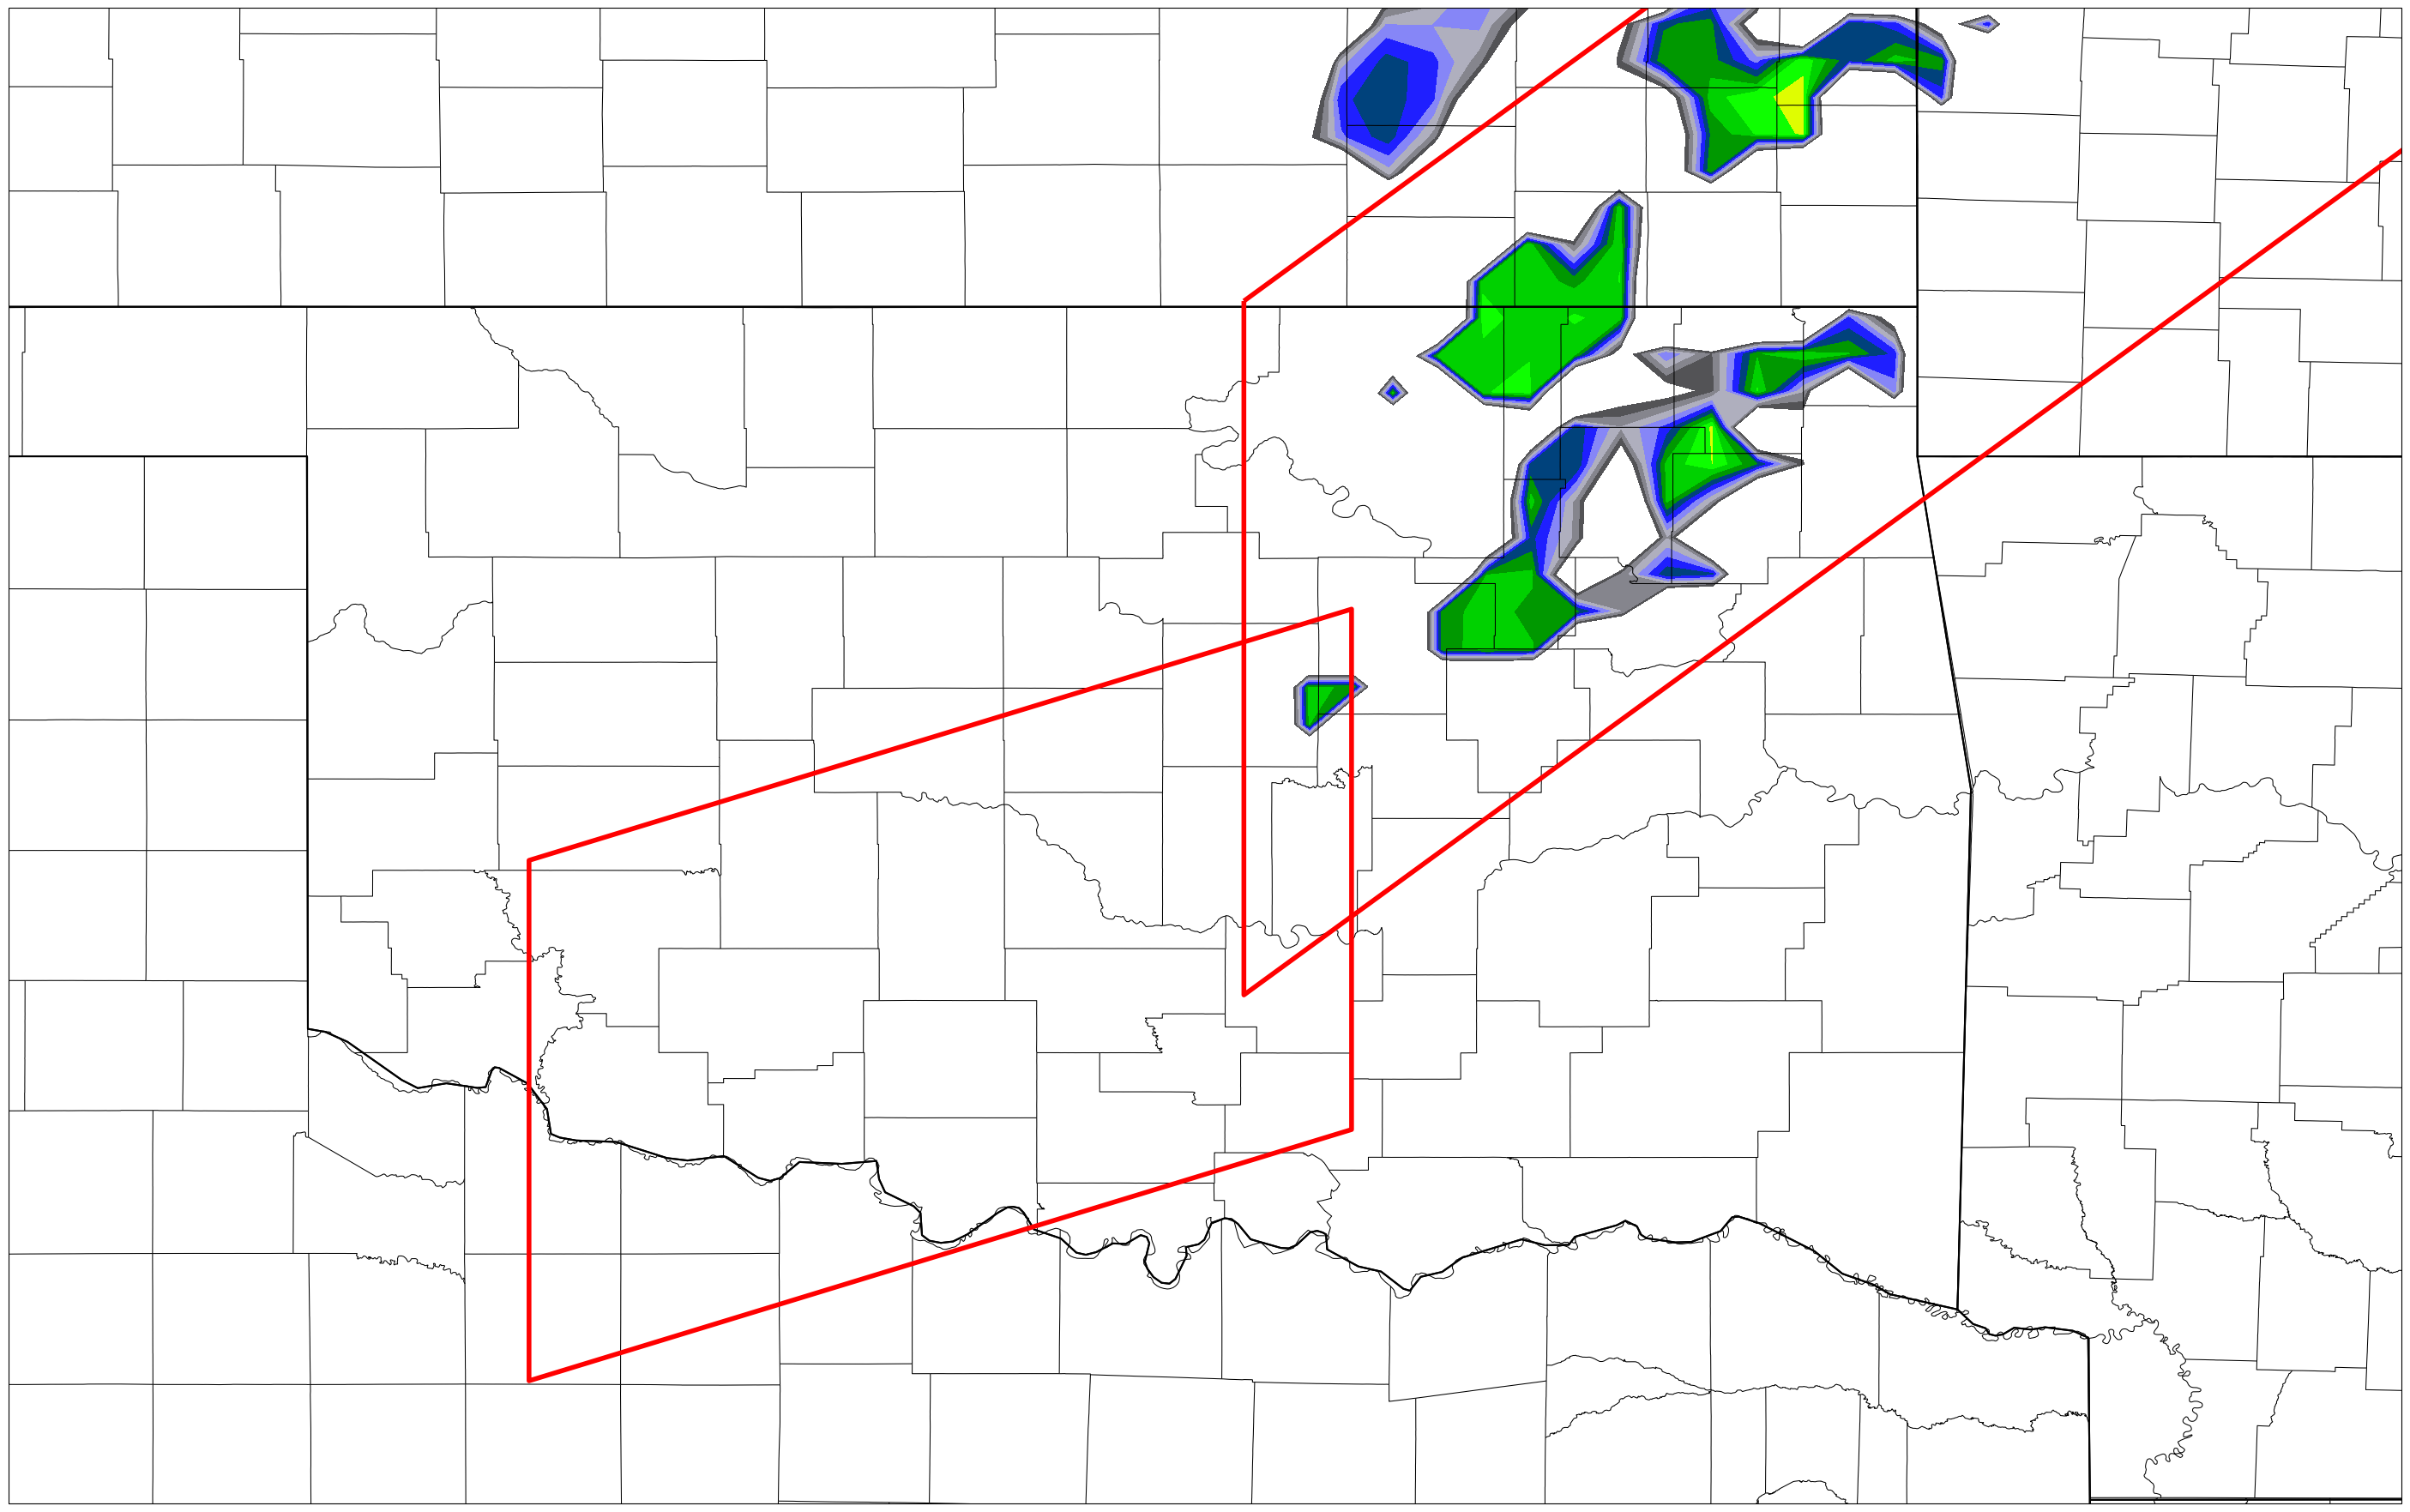

In [18]:
year=2019
month=5
day = 22
hour = 23
Hour = hour

time_start = datetime(int(year), int(month), int(day), int(hour), 0) # Our specified time
hour = time_start.hour
if hour < 10:
    hour = '0'+str(hour)
day = time_start.day
if day < 10:
    day = '0'+str(day)
month = time_start.month
if month < 10:
    month = '0'+str(month)

#ds = xr.open_dataset('https://thredds.ucar.edu/thredds/dodsC/casestudies/python-gallery/NAM_20161031_1200.nc').metpy.parse_cf()
#cat = TDSCatalog('https://www.ncdc.noaa.gov/thredds/catalog/model-rap130-old/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/catalog.html?dataset=rap130-old/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/rap_130_'+str(time_start.year)+str(month)+str(day)+'_'+str(hour)+'00_000.grb2')

#======
file = 0

## 1    
if file == 0:
    try:
        cat = TDSCatalog('https://www.ncei.noaa.gov/thredds/catalog/model-rap130anl-old/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/catalog.html?dataset=rap130anl-old/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/rap_130_'+str(time_start.year)+str(month)+str(day)+'_'+str(hour)+'00_000.grb2')
        file = 1
        print("We have the file we need1!")
    except:
        file = 0
        print("No file yet...")

## 2
if file == 0:
    try:
        cat = TDSCatalog('https://www.ncei.noaa.gov/thredds/catalog/model-ruc130anl-old/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/catalog.html?dataset=ruc130anl-old/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/ruc_130_'+str(time_start.year)+str(month)+str(day)+'_'+str(hour)+'00_000.grb2')
        file = 1
        print("We have the file we need2!")
    except:
        file = 0
        print("No file yet...")
        
## 3
if file == 0:
    try:
        cat = TDSCatalog('https://www.ncei.noaa.gov/thredds/catalog/model-rap252anl-old/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/catalog.html?dataset=rap252anl-old/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/rap_252_'+str(time_start.year)+str(month)+str(day)+'_'+str(hour)+'00_000.grb2')
        file = 1
        print("We have the file we need3!")
    except:
        file = 0
        print("No file yet...")

## 4
if file == 0:
    try:
        cat = TDSCatalog('https://www.ncei.noaa.gov/thredds/catalog/model-ruc252anl-old/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/catalog.html?dataset=ruc252anl-old/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/ruc_252_'+str(time_start.year)+str(month)+str(day)+'_'+str(hour)+'00_000.grb2')
        file = 1
        print("We have the file we need4!")
    except:
        file = 0
        print("No file yet...")        
        
## 1b
if file == 0:
    try:
        cat = TDSCatalog('https://www.ncei.noaa.gov/thredds/catalog/model-rap130anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/catalog.html?dataset=rap130anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/rap_130_'+str(time_start.year)+str(month)+str(day)+'_'+str(hour)+'00_000.grb2')
        file = 1
        print("We have the file we need1b!")
    except:
        file = 0
        print("No file yet...")

## 2b
if file == 0:
    try:
        cat = TDSCatalog('https://www.ncei.noaa.gov/thredds/catalog/model-ruc130anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/catalog.html?dataset=ruc130anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/ruc_130_'+str(time_start.year)+str(month)+str(day)+'_'+str(hour)+'00_000.grb2')
        file = 1
        print("We have the file we need2b!")
    except:
        file = 0
        print("No file yet...")
        
## 3b
if file == 0:
    try:
        cat = TDSCatalog('https://www.ncei.noaa.gov/thredds/catalog/model-rap252anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/catalog.html?dataset=rap252anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/rap_252_'+str(time_start.year)+str(month)+str(day)+'_'+str(hour)+'00_000.grb2')
        file = 1
        print("We have the file we need3b!")
    except:
        file = 0
        print("No file yet...")

## 4b
if file == 0:
    try:
        cat = TDSCatalog('https://www.ncei.noaa.gov/thredds/catalog/model-ruc252anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/catalog.html?dataset=ruc252anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/ruc_252_'+str(time_start.year)+str(month)+str(day)+'_'+str(hour)+'00_000.grb2')
        file = 1
        print("We have the file we need4b!")
    except:
        file = 0
        print("No file yet...")


## 5
#if file == 0:
#    try:
#        cat = TDSCatalog('https://www.ncdc.noaa.gov/thredds/catalog/model-rap130anl-old/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/catalog.html?dataset=rap130anl-old/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/rap_130_'+str(time_start.year)+str(month)+str(day)+'_'+str(hour)+'00_000.grb2')
#        file = 1
#        print("We have the file we need!")
#    except:
#        file = 0
#        print("No file yet...")
        
## 6
#if file == 0:
#    try:
#        cat = TDSCatalog('https://www.ncdc.noaa.gov/thredds/catalog/model-rap130anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/catalog.html?dataset=rap130anl-old/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/rap_130_'+str(time_start.year)+str(month)+str(day)+'_'+str(hour)+'00_000.grb2')
#        file = 1
#        print("We have the file we need...rap130anal!")
#    except:
#        file = 0
#        print("No file yet...rap130anal")

## 7
#if file == 0:
#    try:
#        cat = TDSCatalog('https://www.ncdc.noaa.gov/thredds/catalog/model-rap252anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/catalog.html?dataset=rap130anl-old/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/rap_130_'+str(time_start.year)+str(month)+str(day)+'_'+str(hour)+'00_000.grb2')
#        file = 1
#        print("We have the file we need...rap252anal!")
#    except:
#        file = 0
#        print("No file yet...rap252anal")

## 8
#if file == 0:
#    try:
#        cat = TDSCatalog('https://www.ncei.noaa.gov/thredds/catalog/model-rap130anl-old/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/catalog.html?dataset=rap130anl-old/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/rap_130_'+str(time_start.year)+str(month)+str(day)+'_'+str(hour)+'00_000.grb2')
#        file = 1
#        print("We have the file we need!")
#    except:
#        file = 0
#        print("No file yet...")


## 9
if file == 0:
    try:
        cat = TDSCatalog('http://nomads.ncdc.noaa.gov/thredds/catalog/rap130/'+str(time_start.year)+'0'+str(time_start.month)+'/'+str(time_start.year)+'0'+str(time_start.month)+str(time_start.day)+'/catalog.html?dataset=rap130/'+str(time_start.year)+'0'+str(time_start.month)+'/'+str(time_start.year)+'0'+str(time_start.month)+str(time_start.day)+'/rap_130_'+str(time_start.year)+'0'+str(time_start.month)+str(time_start.day)+'_'+str(time_start.hour)+'00_001.grb2')
        file = 1
        print("We have the file we need!")
    except:
        file = 0
        print("No file yet...")

## 10
if file == 0:
    try:
        cat = TDSCatalog('http://nomads.ncdc.noaa.gov/thredds/catalog/rap130/'+str(year)+str(month)+'/'+str(year)+str(month)+str(day)+'/catalog.html?dataset=rap130/'+str(year)+str(month)+'/'+str(year)+str(month)+str(day)+'/rap_130_'+str(year)+str(month)+str(day)+'_'+str(UTC)+'_000.grb2')
        file = 1
        print("We have the file we need!")
    except:
        file = 0
        print("No file yet...")

## 11
if file == 0:
    try:
        cat = TDSCatalog('https://www.ncei.noaa.gov/thredds/catalog/rap130anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/catalog.html?dataset=rap130anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/rap_130_'+str(time_start.year)+str(month)+str(day)+'_'+str(hour)+'00_000.grb2')
        file = 1
        print("We have the file we need!")
    except:
        file = 0
        print("No file yet...")

## 12
if file == 0:
    try:
        cat = TDSCatalog('https://www.ncdc.noaa.gov/thredds/catalog/model-rap252anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/catalog.html?dataset=rap252anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/rap_252_'+str(time_start.year)+str(month)+str(day)+'_'+str(hour)+'00_000.grb2')
        file = 1
        print("We have the file we need!")
    except:
        file = 0
        print("No file yet...")

## 13
#if file == 0:
#    try:
#        cat = TDSCatalog('https://www.ncei.noaa.gov/thredds/catalog/model-rap252anl-old/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/catalog.html?dataset=rap252anl-old/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/rap_252_'+str(time_start.year)+str(month)+str(day)+'_'+str(hour)+'00_000.grb2') 
#        file = 1
#        print("We have the file we need!")
#    except:
#        file = 0
#        print("No file yet...")

## 14
if file == 0:
    try:
        cat = TDSCatalog('https://www.ncei.noaa.gov/thredds/catalog/model-ruc130anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/catalog.html?dataset=ruc130anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/ruc2anl_130_'+str(time_start.year)+str(month)+str(day)+'_'+str(hour)+'00_000.grb2') 
        file = 1
        print("We have the file we need!")
    except:
        file = 0
        print("No file yet...")

## 15
if file == 0:
    try:
        cat = TDSCatalog('https://www.ncei.noaa.gov/thredds/catalog/model-ruc252anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/catalog.html?dataset=ruc252anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/ruc2anl_252_'+str(time_start.year)+str(month)+str(day)+'_'+str(hour)+'00_000.grb2')
        file = 1
        print("We have the file we need!")
    except:
        file = 0
        print("We didn't get any file!")


latest_ds = list(cat.datasets.values())[0]
#print(latest_ds.access_urls)
ncss = NCSS(latest_ds.access_urls['NetcdfSubset'])
query = ncss.query()
query.variables('Vertical_velocity_pressure_isobaric').variables('Convective_available_potential_energy_surface').variables('u-component_of_wind_isobaric').variables('v-component_of_wind_isobaric').variables('Storm_relative_helicity_height_above_ground_layer').variables('Pressure_surface').variables('Dewpoint_temperature_height_above_ground').variables('Temperature_height_above_ground').variables('Vertical_u-component_shear_height_above_ground_layer').variables('Vertical_v-component_shear_height_above_ground_layer').variables('Geopotential_height_isobaric').variables('Geopotential_height_surface').variables('u-component_of_wind_height_above_ground').variables('v-component_of_wind_height_above_ground').variables('Relative_humidity_isobaric').variables('Temperature_isobaric').variables('Composite_reflectivity_entire_atmosphere')
data1 = ncss.get_data(query)

dtime = data1.variables['Geopotential_height_isobaric'].dimensions[0]
dlev = data1.variables['Geopotential_height_isobaric'].dimensions[1]
dlat = data1.variables['Geopotential_height_isobaric'].dimensions[2] #y
dlon = data1.variables['Geopotential_height_isobaric'].dimensions[3] #x

lats_r = data1.variables[dlat][:]
lons_r= data1.variables[dlon][:]
lev = (np.asarray(data1.variables[dlev][:])/100.) * units('hPa')

# Set up our array of latitude and longitude values and transform to the desired projection.
crs = ccrs.PlateCarree()
crlons, crlats = np.meshgrid(lons_r[:]*1000, lats_r[:]*1000)
trlatlons = crs.transform_points(ccrs.LambertConformal(central_longitude=-95, central_latitude=25),crlons,crlats)
trlons = trlatlons[:,:,0]
trlats = trlatlons[:,:,1]

SFCP = (np.asarray(data1.variables['Pressure_surface'][:])/100.) * units('hPa')
Td = (np.asarray(data1.variables['Dewpoint_temperature_height_above_ground'][:]) * units('kelvin')).to('degC')
T = np.asarray(data1.variables['Temperature_height_above_ground'][:]) * units('kelvin')
hgt = np.asarray(data1.variables['Geopotential_height_isobaric'][:]) * units('meter')
sfc_hgt = np.asarray(data1.variables['Geopotential_height_surface'][:]) * units('meter')
uwnd = np.asarray(data1.variables['u-component_of_wind_isobaric'][:]) * units('m/s')
vwnd = np.asarray(data1.variables['v-component_of_wind_isobaric'][:]) * units('m/s')
Temp_up = np.asarray(data1.variables['Temperature_isobaric'][:]) * units('kelvin')
VVEL_up = np.asarray(data1.variables['Vertical_velocity_pressure_isobaric'][:]) * units('Pa/s')
RH_up = np.asarray(data1.variables['Relative_humidity_isobaric'][:])
usfc = np.asarray(data1.variables['u-component_of_wind_height_above_ground'][:]) * units('m/s')
vsfc = np.asarray(data1.variables['v-component_of_wind_height_above_ground'][:]) * units('m/s')
COMP = data1.variables['Composite_reflectivity_entire_atmosphere'][:]

theta_e = equivalent_potential_temperature(SFCP, T, Td)

reader = shpreader.Reader(r"C:\Users\kyled\Desktop\Thesis GIS Data\County1010\countyl010g.shp")
counties = list(reader.geometries())
COUNTIES = cfeature.ShapelyFeature(counties, ccrs.PlateCarree())

reader1 = shpreader.Reader(r"C:\Users\kyled\Desktop\Thesis GIS Data\watches_201905221800_201905222232\watches_201905221800_201905222232.shp")
watchboxes = list(reader1.geometries())
WATCHES = cfeature.ShapelyFeature(watchboxes, ccrs.PlateCarree())

proj = ccrs.PlateCarree()

fig=plt.figure(figsize = (36,36))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.STATES.with_scale('50m'), linestyle='-', edgecolor='black', linewidth=1.5)
ax.add_feature(COUNTIES, facecolor='none', edgecolor='black', linewidth=0.75)
ax.add_feature(WATCHES, facecolor='none', edgecolor='red', linewidth=4.0)
#ax.set_extent([-104, -93, 32, 39])
#ax.set_extent([-101, -91, 32.25,39.25])
ax.set_extent([-101.0, -93.0, 33.0, 38.0])

#ax.barbs(x = trlons[6:6], y = trlats[6:6], u = uwnd[0][36][6:6], v = vwnd[0][36][6:6], length=10,linewidth=3.0, color='black')
#ax.barbs(x = trlons[6::], y = trlats[6::], u = uwnd[0][36][6::], v = vwnd[0][36][6::], length=10,linewidth=3.0, color='black')
#ax.barbs(x = trlons[::3,::3], y = trlats[::3,::3], u = uwnd[0][36][::3,::3], v = vwnd[0][36][::3,::3], length=10,linewidth=3.0, color='black')


cmap1 = plt.get_cmap(ctables.REF_pmarsh)
ref_table = truncate_colormap(cmap1, 0, 1)
cf1 = ax.contourf(trlons, trlats, COMP[0], range(20,70, 2), cmap=ref_table) # Make a filled contour plot


#cf = ax.contourf(trlons, trlats, RH_up[0][36], range(50,105, 5), cmap="YlGn") # Make a filled contour plot
#ax.barbs(x = trlons[::3], y = trlats[::3], u = uwnd[0][36][::3], v = vwnd[0][36][::3], length=8,linewidth=1.5, color='black')



#df1 = pd.read_csv("C:/Users/kyled/Desktop/NI_Points_CSVs/5_22_VerticalProfs_QC.csv")
#markersize = 75

#df = df1[df1.Grouping==1][df1.Time==Hour]
#x = df.Lon
#y = df.Lat
#ax.plot(x, y, color='red', marker='*', markersize = markersize)

#plt.title('RAP Composite Reflectivity '+str(year)+str(month)+str(day)+'_'+str(hour)+'z', fontsize=36)
#plt.title('RAP surface winds (black) & 850 mb (red) winds '+str(year)+str(month)+str(day)+'_'+str(hour)+'z', fontsize=36)
#cbar = plt.colorbar(cf1, extend='max', aspect=75, shrink=0.55, pad=0.01,extendrect='True')
#cbar = plt.colorbar(cf1, shrink=0.55, pad=0.01)
#cbar.ax.tick_params(labelsize=20) 

plt.savefig(r"C:\Users\kyled\Desktop\RAP_CompREF_"+str(year)+str(month)+str(day)+"_"+str(hour)+"z.png", bbox_inches='tight')

#print(np.amax(theta_e))
#print(np.amin(theta_e))
#plt.switch_backend('Agg')
#plt.show()
#plt.imshow(SFCP[0])
#plt.colorbar()

In [13]:
data1

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    Originating_or_generating_Center: US National Weather Service, National Centres for Environmental Prediction (NCEP)
    Originating_or_generating_Subcenter: 0
    GRIB_table_version: 2,1
    Type_of_generating_process: Forecast
    Analysis_or_forecast_generating_process_identifier_defined_by_originating_centre: Rapid Refresh (RAP)
    Conventions: CF-1.6
    history: Read using CDM IOSP GribCollection v3
    featureType: GRID
    History: Translated to CF-1.0 Conventions by Netcdf-Java CDM (CFGridWriter2)
Original Dataset = /san5302/nexus/rucanl/201905/20190523/rap_130_20190523_0200_000.grb2; Translation Date = 2023-06-07T21:27:34.886Z
    geospatial_lat_min: 16.20865486388938
    geospatial_lat_max: 55.51675688158025
    geospatial_lon_min: -139.9699067110668
    geospatial_lon_max: -57.26853740515435
    dimensions(sizes): time(1), y(337), x(451), height_above_ground_layer1(1), isoba